In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tike
import xdesign as xd

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
NPIXEL = 16
PIXEL_SIZE = 1/NPIXEL
TOTAL_TIME = 1.0
region = np.array([[-PIXEL_SIZE, PIXEL_SIZE], [-1, 1], [-1, 1]])/2
ideal_mean = TOTAL_TIME * PIXEL_SIZE
S_FREQ = 1/2**11
NANGLES = 16

def circle_density(x, y, radius=PIXEL_SIZE/2):
    """Return True for (x,y) contained by the circle with given radius"""
    return x**2 + y**2 <= radius**2


probe = tike.Probe(density_profile=None,
                   width=PIXEL_SIZE,
                   aspect=1.0)

def get_mask(A):
    """Return a boolean mask for dimensions 1 & 2 of A"""
    assert A.shape[1] == A.shape[2]
    radius = A.shape[1] / 2.0
    coords = np.arange(A.shape[1]) - A.shape[1] / 2.0 + 0.5,
    x, y = np.meshgrid(coords, coords)
    mask = circle_density(x, y, radius=radius)
    return mask


def get_metric(coverage):
    """Return the standard deviation from the ideal coverage from the region
    inside the cylindrical mask
    """
    ideal_mean = TOTAL_TIME * PIXEL_SIZE
    if coverage.ndim > 3:
        coverage = np.linalg.eigvalsh(coverage)
    x = coverage[:, get_mask(coverage), :].flatten()
    metric = np.sqrt(np.sum((ideal_mean/2 - x)**2) / x.size) - np.mean(x)
    return metric

def fly2D(t, N_rotation=0):
    h = t / TOTAL_TIME - 0.5 #* (1 + PIXEL_SIZE)
    v = 0 * t
    theta = np.pi/3 +  N_rotation * 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def raster2Dt(t, N_raster=1):
    h = tike.triangle(0.5, N_raster/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def raster2Ds(t, N_raster=1):
    h = tike.sinusoid(0.5, N_raster/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def semifly(t, N_raster=1):
    h = tike.triangle(0.5, N_raster/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + tike.staircase(np.pi/N_raster, N_raster, 0, t)
    return theta, h, v

In [3]:
# fake up the array of the scalar mappable. Urgh…
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []

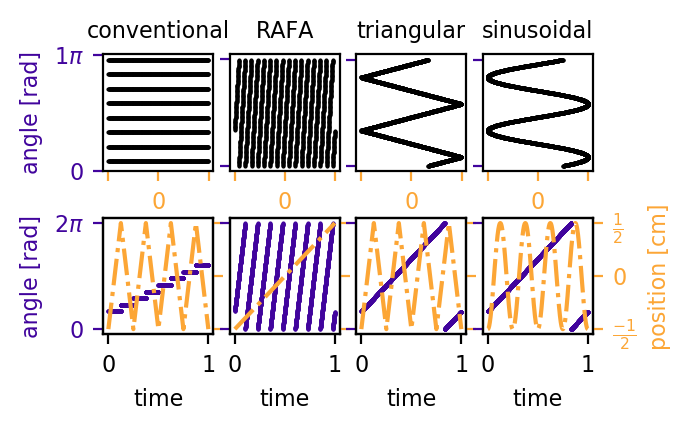

In [4]:
blue = plt.cm.plasma(0.1)
red = plt.cm.plasma(0.8)

plt.figure(figsize=(8.4/2.54, 2), dpi=200)

ax1a = plt.subplot(2,4,4+1)
t = np.arange(0,1,S_FREQ) + S_FREQ/2
th, h, v = semifly(t, 8)
ax1a.plot(t, th%(2*np.pi), '.', color=blue, markersize=1)
ax1a.tick_params('y', colors=blue)
plt.xlabel('time', fontsize=8)
plt.yticks([0, np.pi*2])
ax1a.get_yaxis().set_ticklabels([r'0', r'2$\pi$'], fontsize=8)
plt.ylabel('angle [rad]', color=blue, fontsize=8)
plt.xticks([0, 1], fontsize=8)

ax2 = ax1a.twinx()
ax2.plot(t, h,'-.', color=red)
# ax2.set_ylabel('position [cm]', color=red, fontsize=8)
ax2.tick_params('y', colors=red)
# ax2.get_yaxis().set_ticklabels([])
plt.setp(ax2.get_yticklabels(), visible=False)

b1 = plt.subplot(2,4,1)
plt.title('conventional', fontsize=8)
b1.plot(h, th % np.pi, '.', color='black', markersize=1)
plt.xticks([-.5, 0, 0.5], ['', 0, ''], color=red)
plt.yticks([0, np.pi], [0, '$1\pi$'], color=blue)
b1.tick_params('y', colors=blue)
b1.tick_params('x', colors=red)
plt.ylabel('angle [rad]', color=blue, fontsize=8)

########
ax1 = plt.subplot(2,4,4+2, sharey=ax1a)


# t = np.arange(0,1,S_FREQ) + S_FREQ/2
th, h, v = fly2D(t, N_rotation=8)
ax1.plot(t, th%(2*np.pi), '.', color=blue, markersize=1)
ax1.tick_params('y', colors=blue)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.yticks([0, np.pi*2])
plt.xlabel('time', fontsize=8)
plt.xticks([0, 1], fontsize=8)

ax2 = ax1.twinx()
ax2.plot(t, h,'-.', color=red)
ax2.tick_params('y', colors=red)
ax2.get_yaxis().set_ticklabels([])
plt.xlabel('time', fontsize=8)


b1 = plt.subplot(2,4,2)
plt.title('RAFA', fontsize=8)
b1.plot(h, th % np.pi, '.', color='black', markersize=1)
plt.xticks([-.5, 0, 0.5], ['', 0, ''], color=red, fontsize=8)
plt.yticks([0, np.pi], ['', ''], color=blue)
b1.tick_params('y', colors=blue)
b1.tick_params('x', colors=red)

#####################
ax1 = plt.subplot(2,4,4+3, sharey=ax1a)

# t = np.arange(0,1,S_FREQ) + S_FREQ/2
th, h, v = raster2Dt(t, 8)
ax1.plot(t, th%(2*np.pi), '.', color=blue, markersize=1)
ax1.tick_params('y', colors=blue)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.xlabel('time', fontsize=8)
plt.xticks([0, 1], fontsize=8)

ax2 = ax1.twinx()
ax2.plot(t, h,'-.', color=red)
ax2.tick_params('y', colors=red)
ax2.get_yaxis().set_ticklabels([])
# ax1.tick_params('y', colors=blue)
# plt.xlabel('time', fontsize=8)


b1 = plt.subplot(2,4,3)
plt.title('triangular', fontsize=8)
b1.plot(h, th % np.pi, '.', color='black', markersize=1)
plt.xticks([-.5, 0, 0.5], ['', 0, ''], color=red)
plt.yticks([0, np.pi], ['', ''], color=blue)
b1.tick_params('y', colors=blue)
b1.tick_params('x', colors=red)

##########################
ax1 = plt.subplot(2,4,4+4, sharey=ax1a)
ax1.tick_params('y', colors=blue)
plt.xlabel('time', fontsize=8)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.xticks([0, 1], fontsize=8)

t = np.arange(0,1,S_FREQ) + S_FREQ/2
th, h, v = raster2Ds(t, 8)
ax1.plot(t, th%(2*np.pi), '.', color=blue, markersize=1)
ax2 = ax1.twinx()
ax2.plot(t, h,'-.', color=red)
ax2.tick_params('y', colors=red)
ax2.get_yaxis().set_ticklabels([r'$\frac{-1}{2}$', r'0', r'$\frac{1}{2}$'], fontsize=8)
ax2.set_ylabel('position [cm]', color=red, fontsize=8)
plt.yticks([-.5, 0, .5])

# ax1.get_yaxis().set_ticklabels([r'0', r'2$\pi$'])
b1 = plt.subplot(2,4,4)
plt.title('sinusoidal', fontsize=8)
b1.plot(h, th % np.pi, '.', color='black', markersize=1)
plt.xticks([-.5, 0, 0.5], ['', 0, ''], color=red)
plt.yticks([0, np.pi], ['', ''], color=blue)
b1.tick_params('y', colors=blue)
b1.tick_params('x', colors=red)


plt.subplots_adjust(wspace=0.15, hspace=0.4, top=0.90, bottom=0.20, left=0.135, right=0.875)

plt.savefig('./figures/trajectory_compare.pdf', dpi=600)
plt.savefig('./figures/trajectory_compare.png', dpi=600)

plt.show()

# 2D coverage as a function of rotation speed

Show a bunch of plots as a function of number of rotations per raster traversal.

In [9]:
num_rotations = 2 ** np.arange(0,6)
num_rasters = num_rotations

In [10]:
def triple_plot(cmap, trajectory, NR):
    fig = plt.figure(figsize=(9,3), dpi=200)
    plt.suptitle("{} rotations per raster".format(num_rotations[i]), y=0.0)

    plt.subplot(1,3,1)
    plt.title('real space coverage')
    mask = get_mask(cmap)
    cm = cmap[0,...]
    cm[~mask, ...] = np.nan
    xd.plot_coverage_anisotropy(cm, trace_normal=(2*ideal_mean), color='coverage')
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    
    ax1 = plt.subplot(1,3,2)
    plt.title('trajectory')
    plt.xlabel('time')
    plt.ylabel('angle [rad]', color='b')
    t = np.arange(0,1,S_FREQ)
    th, h, v = trajectory(t, NR)
    ax1.plot(t, th%(2*np.pi), 'b.')
    ax2 = ax1.twinx()
    ax2.plot(t, h,'r-.')
    ax2.set_ylabel('position [cm]', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.subplot(1,3,3)
    hist, x, y, none = plt.hist2d(h, th%(np.pi), weights=None,
                                  bins=2*NPIXEL,
                                  range=[[-.5, .5], [0, np.pi]],)
    plt.cla()
    plt.imshow((hist).T, vmin=0, origin='lower', cmap='magma')
    plt.title('radon space coverage')
    plt.xticks([-.5, 2*NPIXEL-.5],[-.5, 0.5])
    plt.yticks([-.5, 2*NPIXEL-.5], [0, '$1\pi$'])
#     plt.colorbar(orientation='horizontal')
    
    cbaxes = fig.add_axes([0.015, 0.02, 0.30, 0.06]) 
    plt.colorbar(sm, cax = cbaxes, orientation='horizontal',
                 ticks=[0, 0.5, 1, 1.5, 2], label='coverage / ideal coverage')
    
    plt.tight_layout()
    plt.show()

## Rotation as fast axis

In [11]:
fly_coverage_maps = list()
for R in num_rasters:
    kwargs = {'N_rotation' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = probe.coverage(trajectory=fly2D, region=region,
                              pixel_size=PIXEL_SIZE,
                              tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                              tkwargs=kwargs, anisotropy=NANGLES)
    fly_coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 128 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 256 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 512 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 1,024 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 2,048 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 4,096 lines
INFO:root: coverage 4,096 element grid


/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


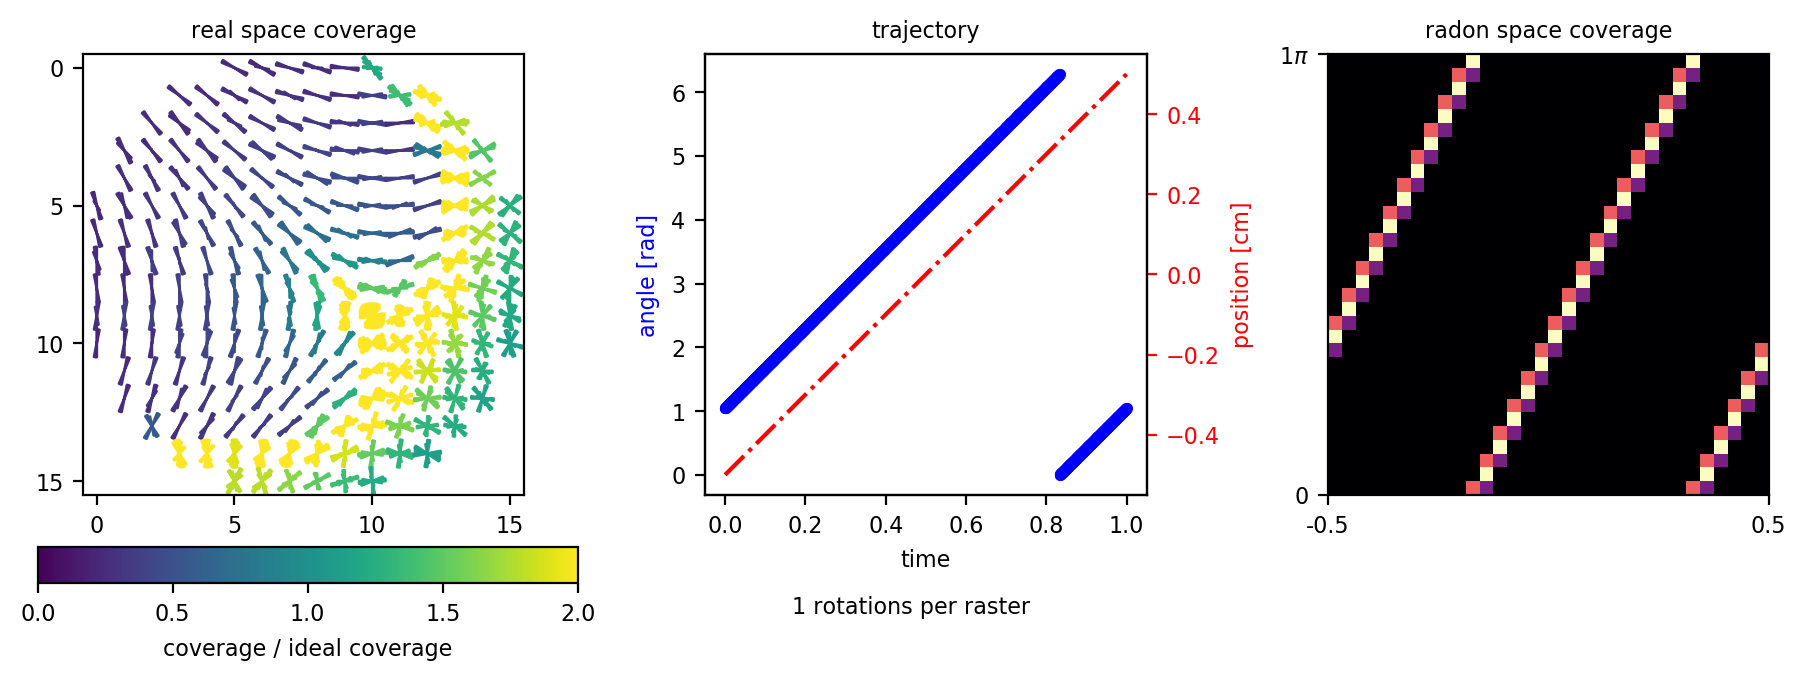

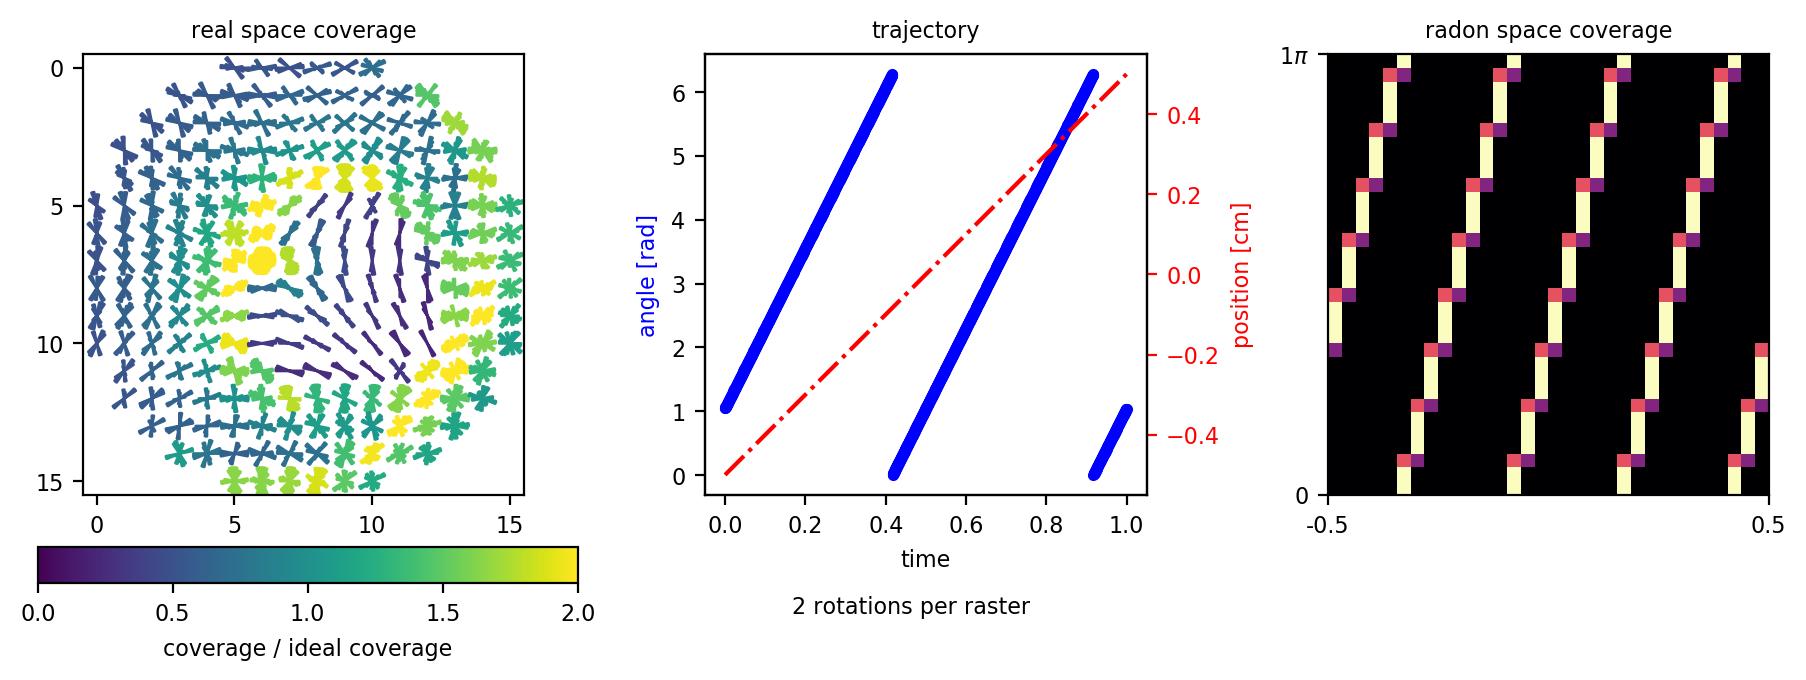

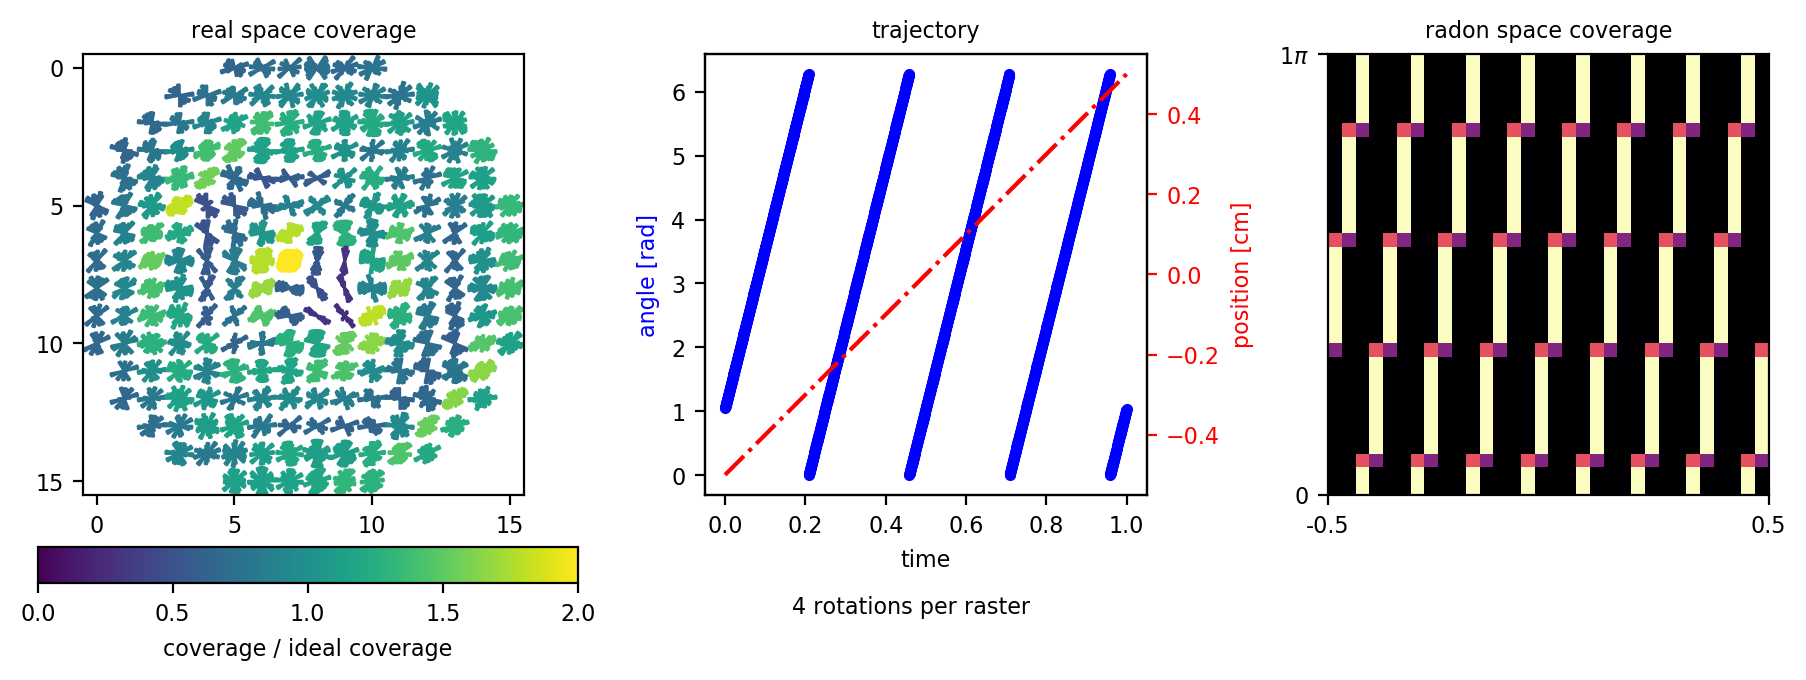

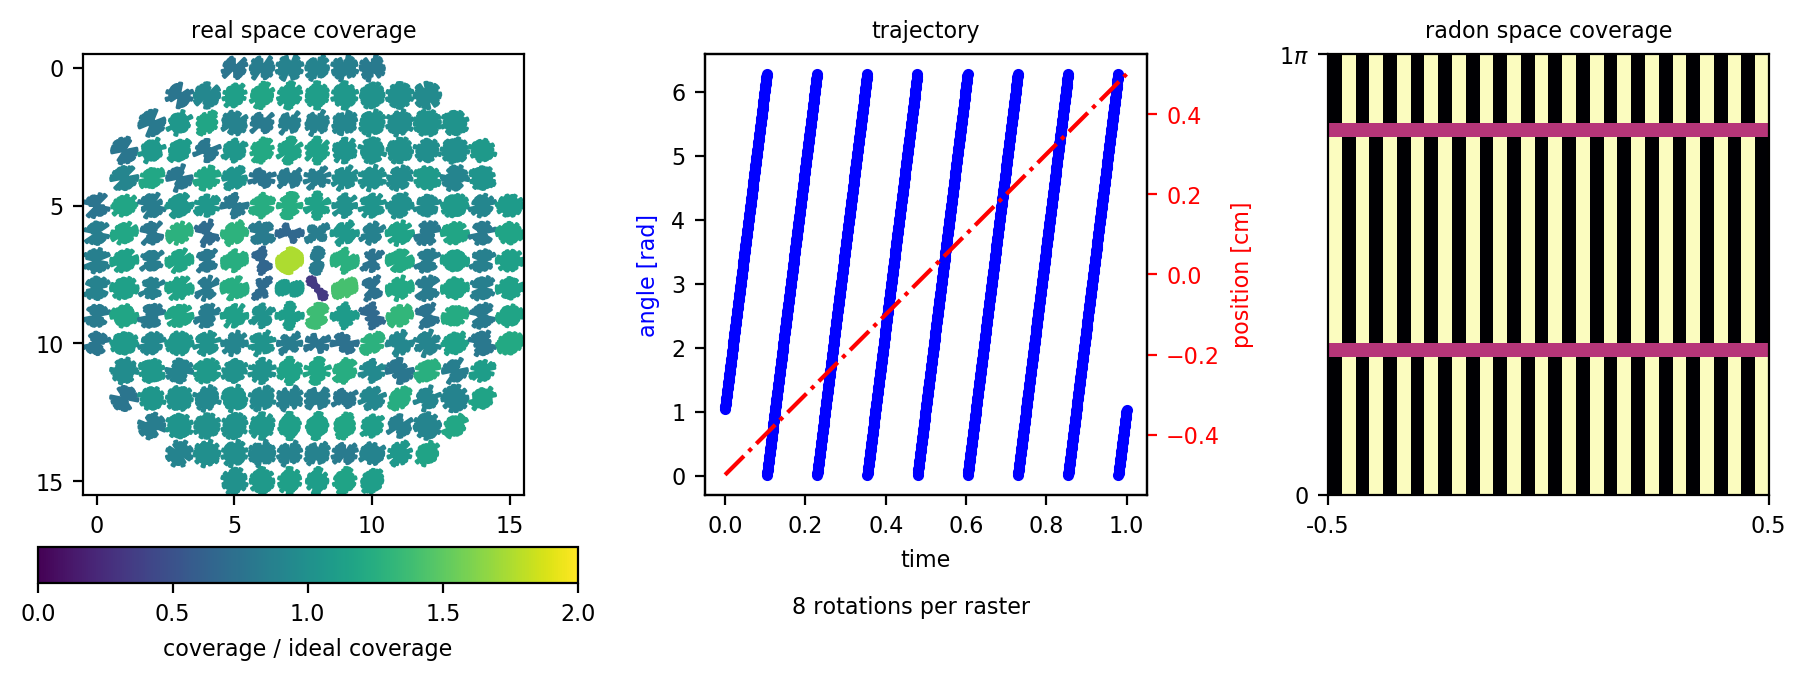

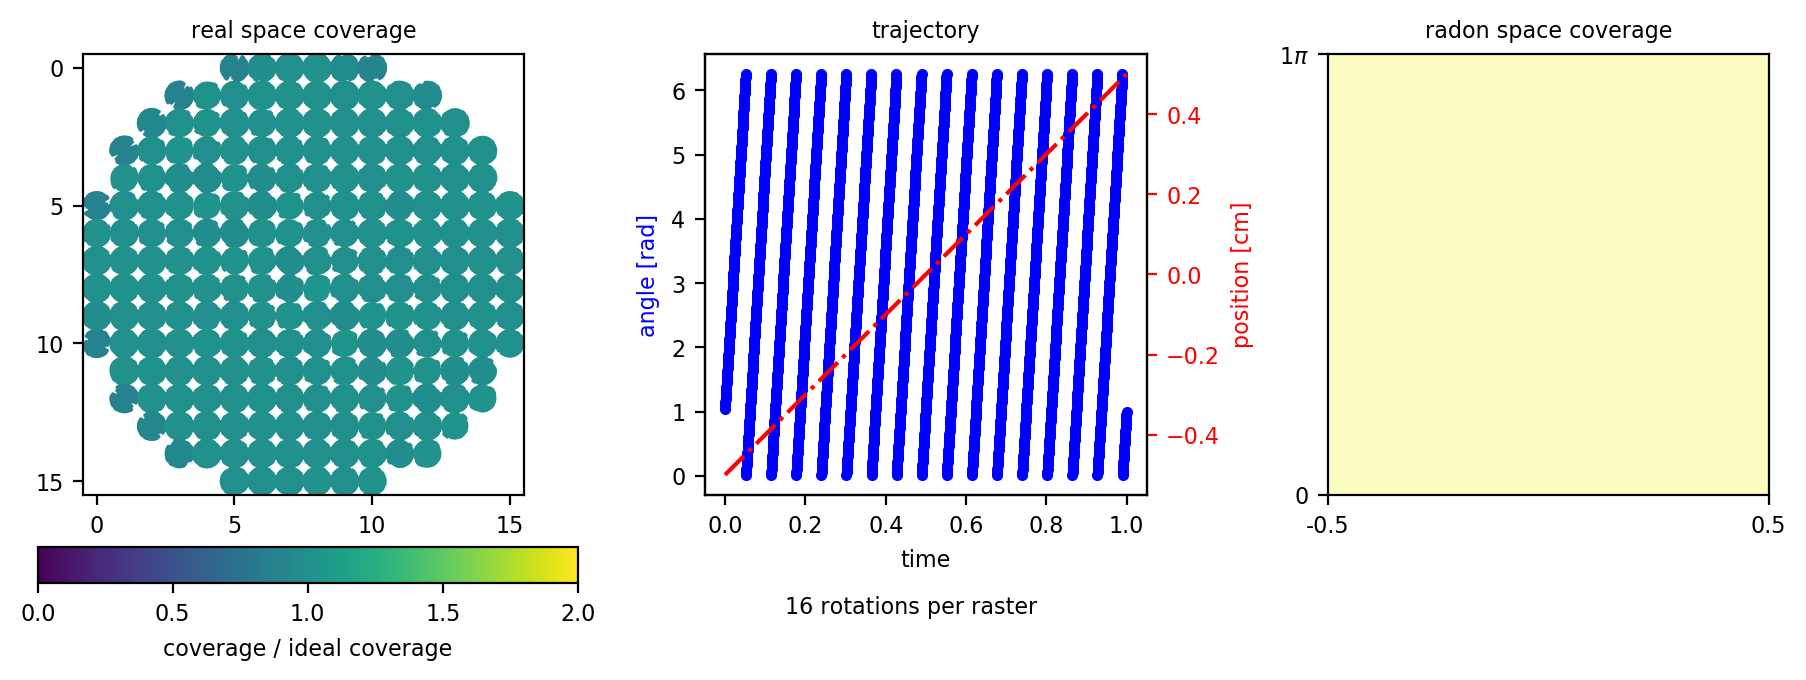

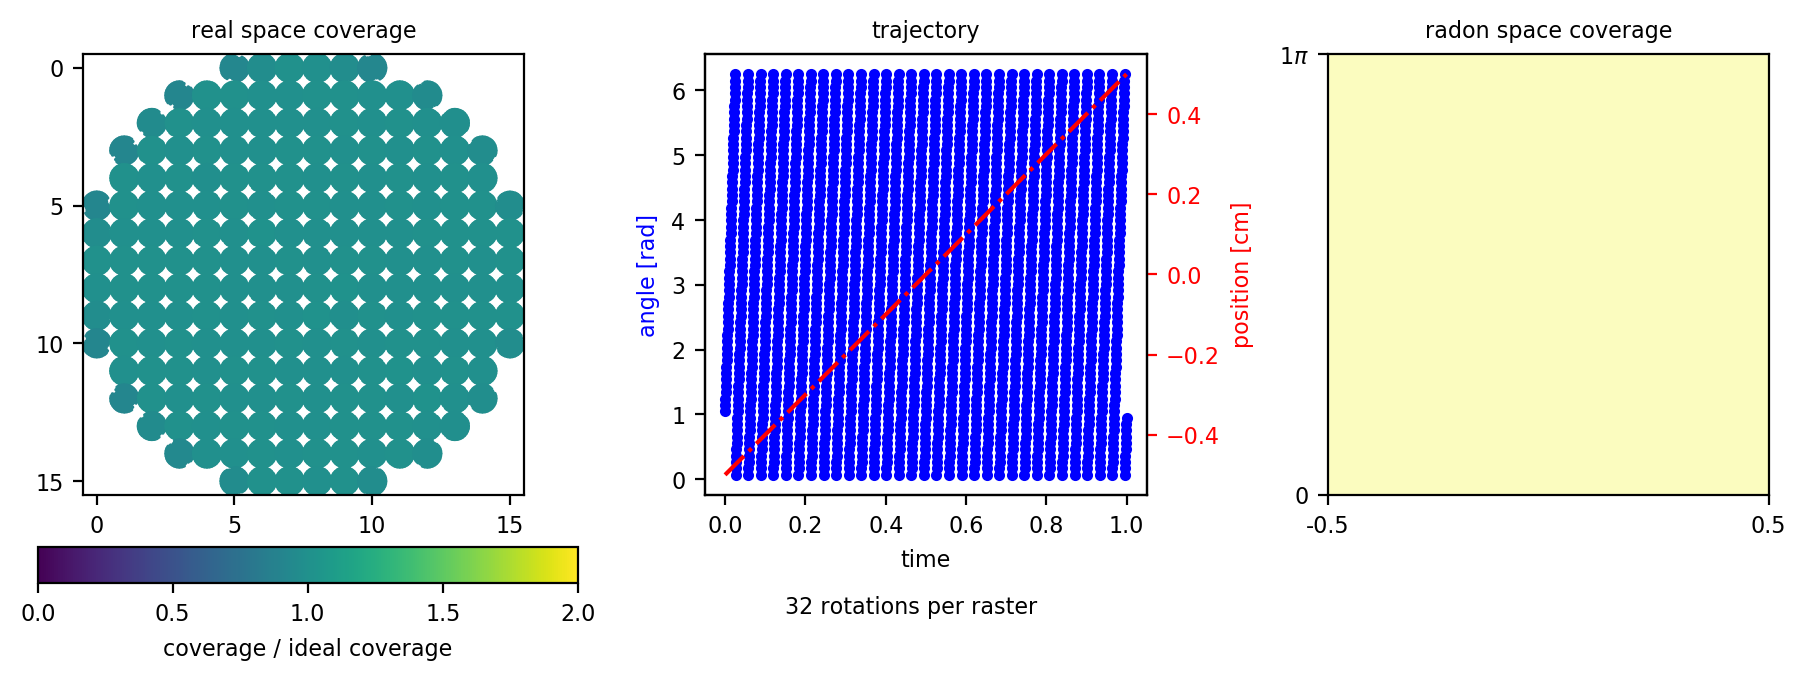

In [12]:
for i in range(len(fly_coverage_maps)):
    triple_plot(fly_coverage_maps[i], fly2D, num_rotations[i])

## Conventional

In [13]:
# More traversals than rotations  - conventional
num_rasters = num_rotations
con_coverage_maps = list()
for R in num_rasters:
    kwargs = {'N_raster' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = np.zeros([1, NPIXEL, NPIXEL, NANGLES])
    for i in range(R):   
        coverage += probe.coverage(trajectory=semifly, region=region,
                                  pixel_size=PIXEL_SIZE,
                                  tmin=i/R*TOTAL_TIME, tmax=(i+1)/R*TOTAL_TIME, tstep=tstep_guess,
                                  tkwargs=kwargs, anisotropy=NANGLES)
    con_coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 79 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 79 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 78 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 79 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 78 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 80 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1

INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 77 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 77 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 77 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 77 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 77 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 77 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1

/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


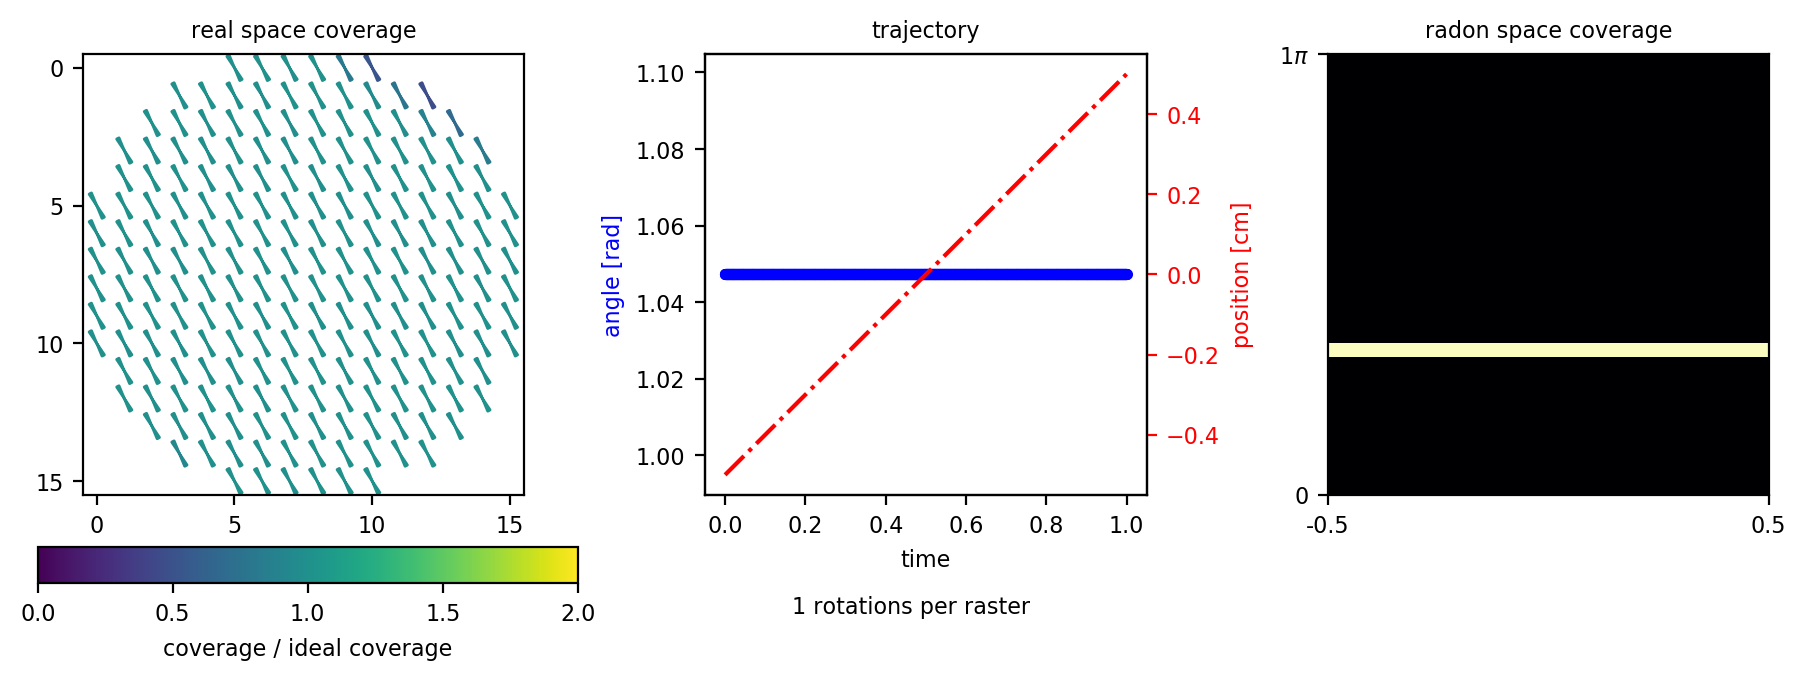

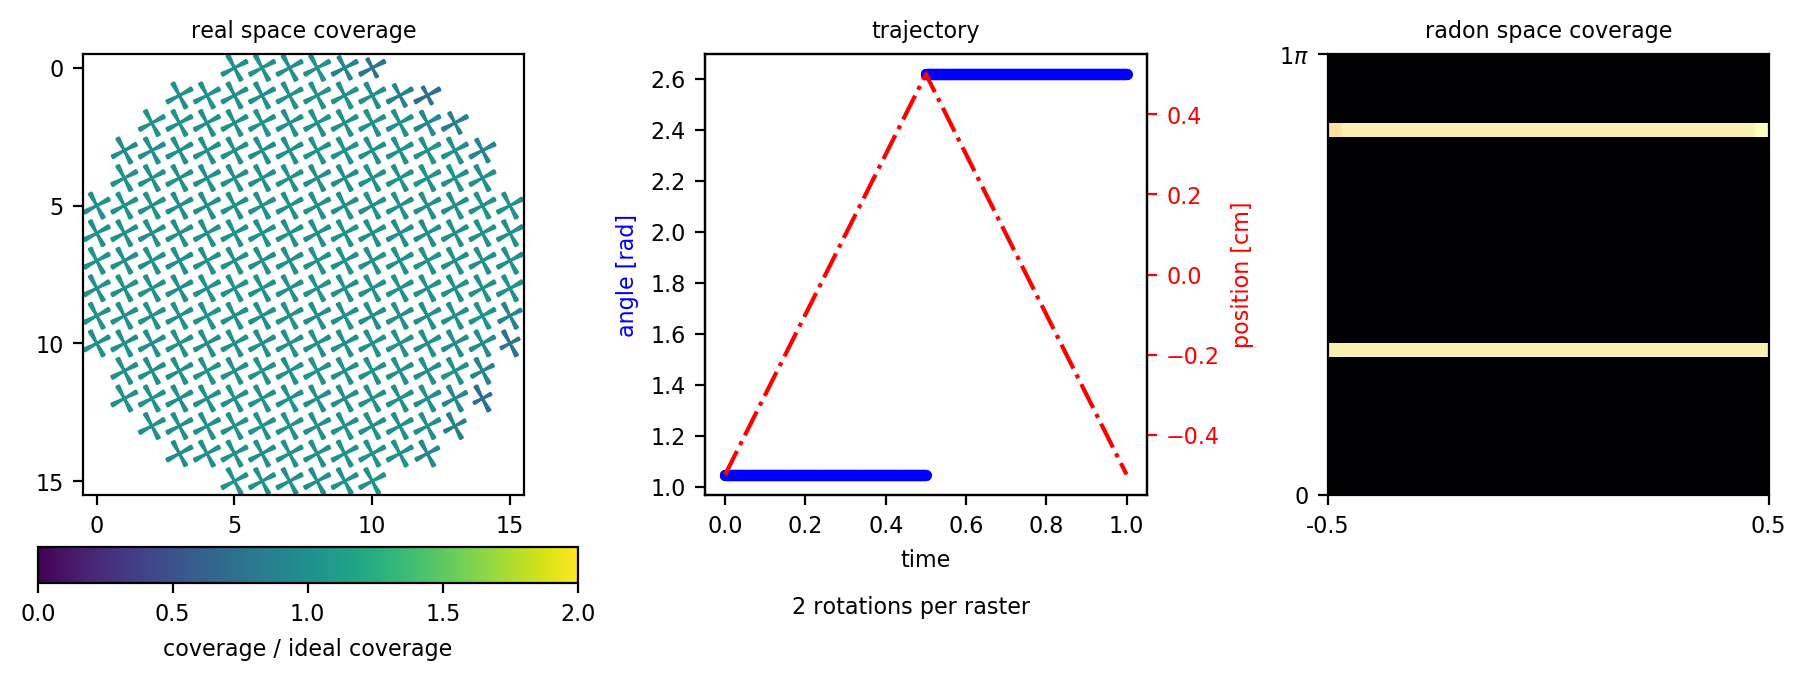

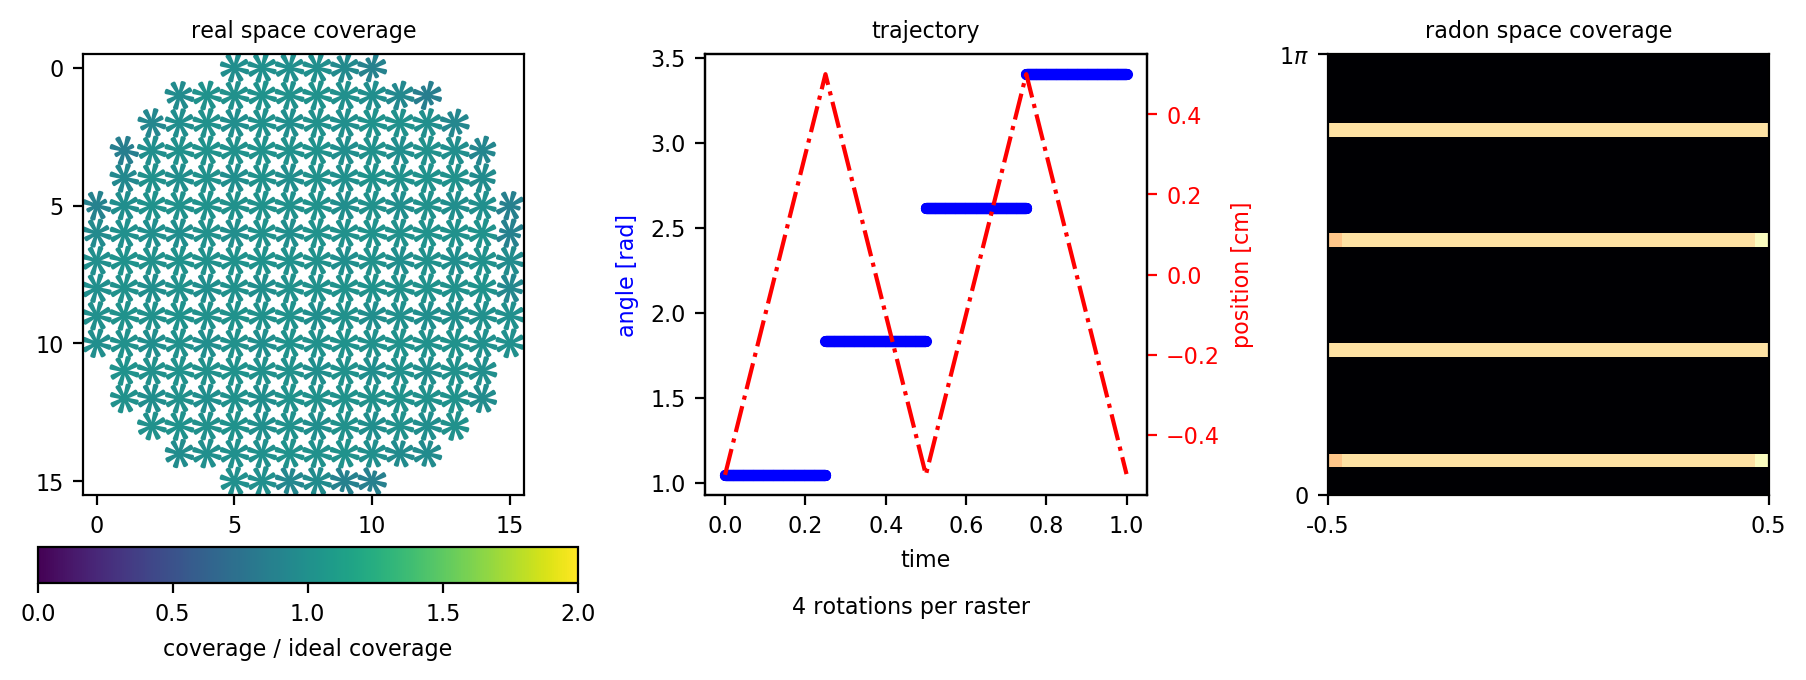

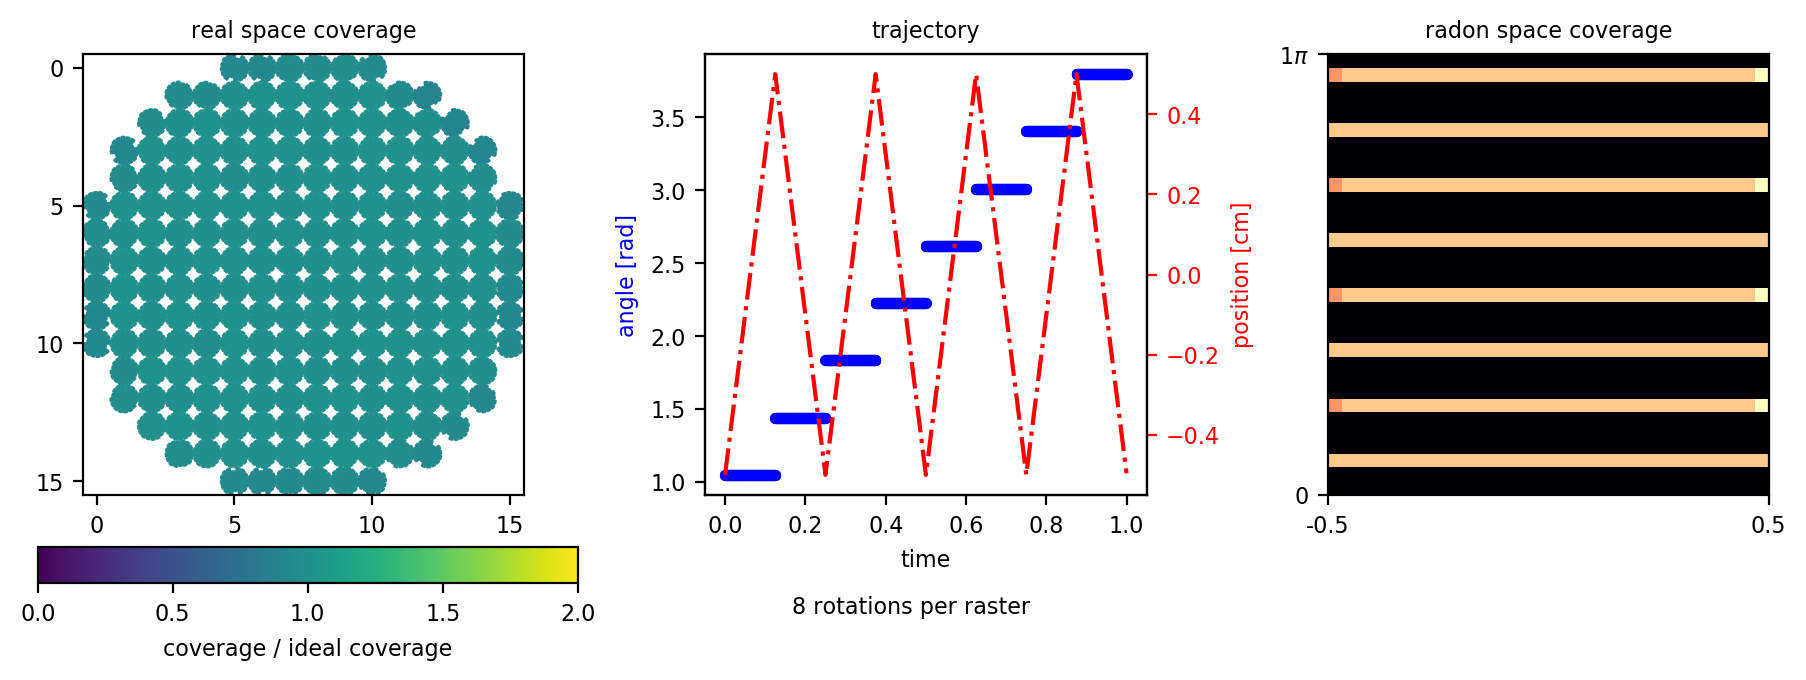

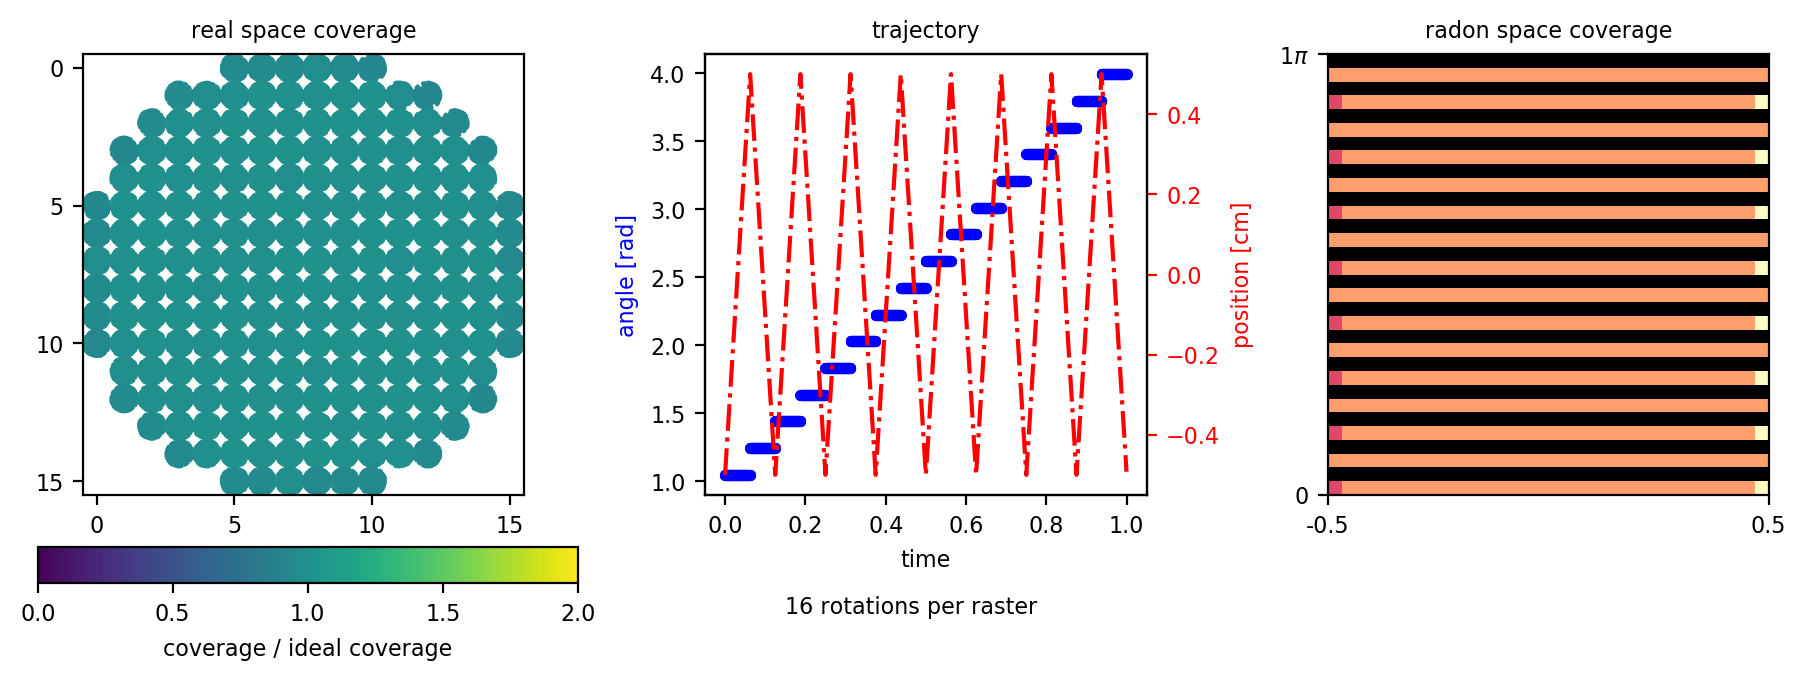

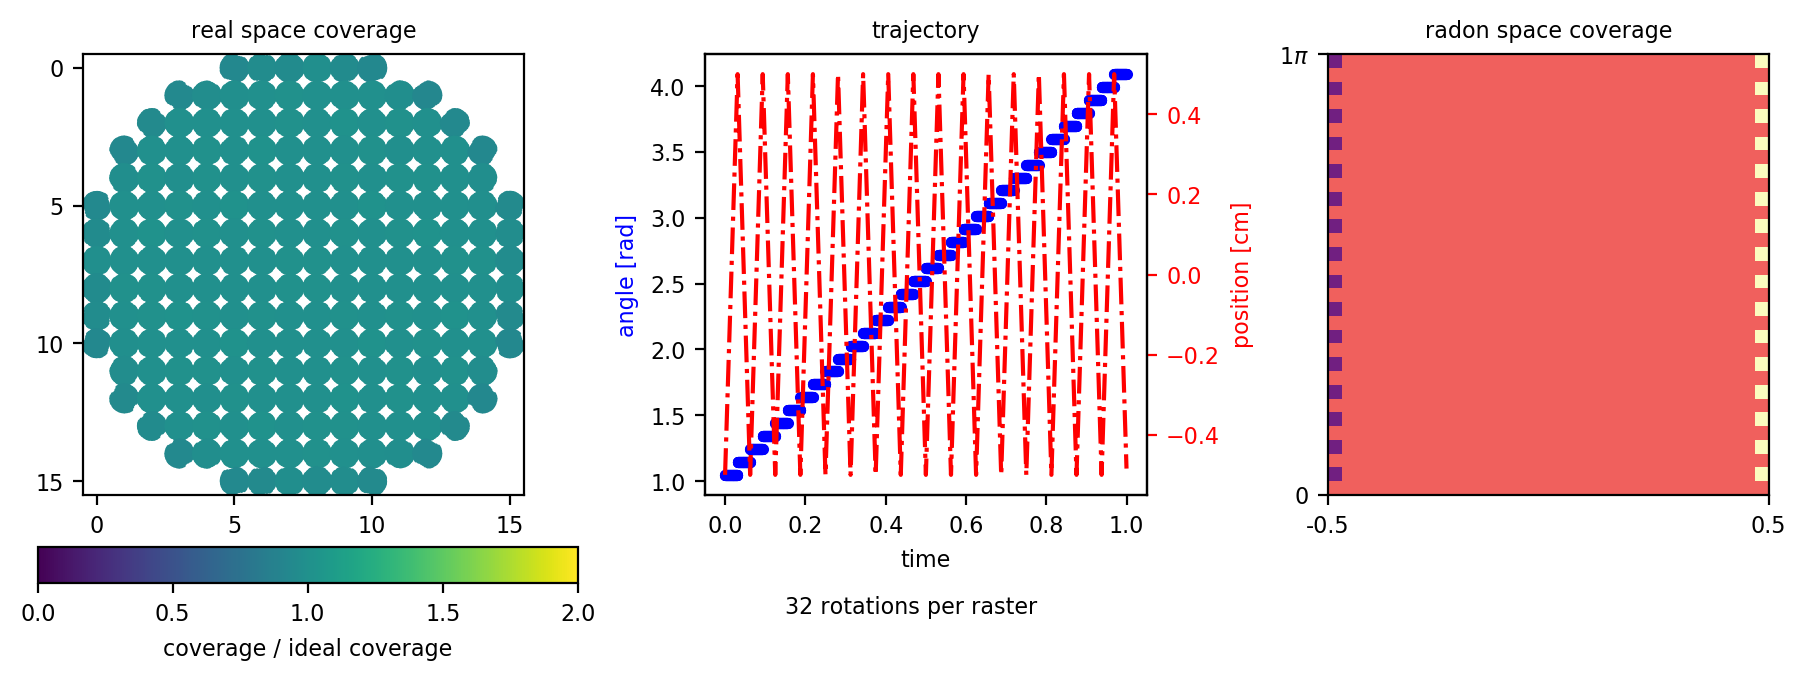

In [14]:
for i in range(len(con_coverage_maps)):
    triple_plot(con_coverage_maps[i], semifly, num_rotations[i])

## Triangle

In [15]:
# More traversals than rotations
num_rasters = num_rotations
tri_coverage_maps = list()
for R in num_rasters:
    kwargs = {'N_raster' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = probe.coverage(trajectory=raster2Dt, region=region,
                              pixel_size=PIXEL_SIZE,
                              tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                              tkwargs=kwargs, anisotropy=NANGLES)
    tri_coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 128 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 128 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 256 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 256 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 512 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 1,024 lines
INFO:root: coverage 4,096 element grid


/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


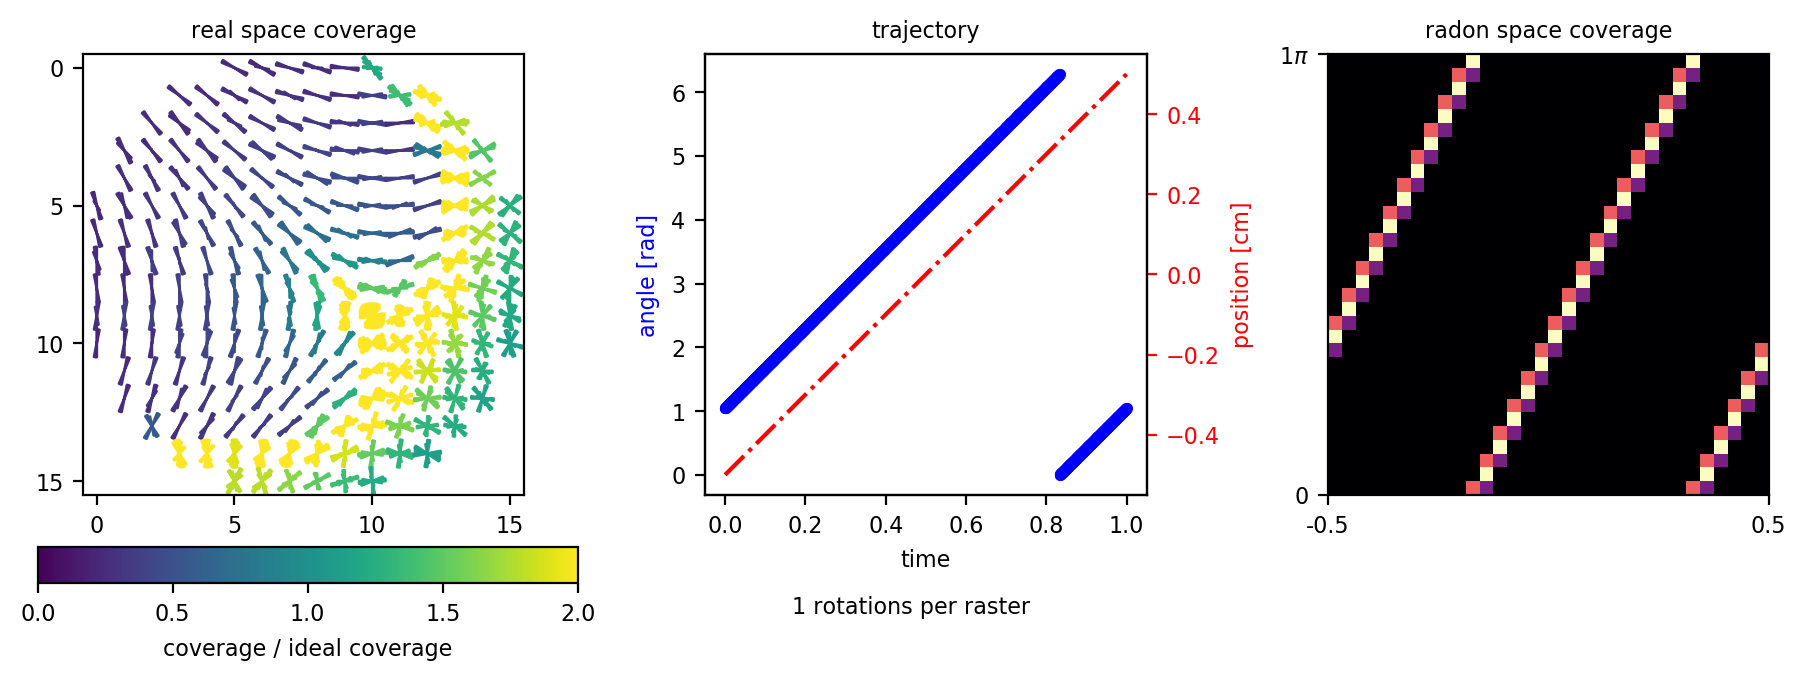

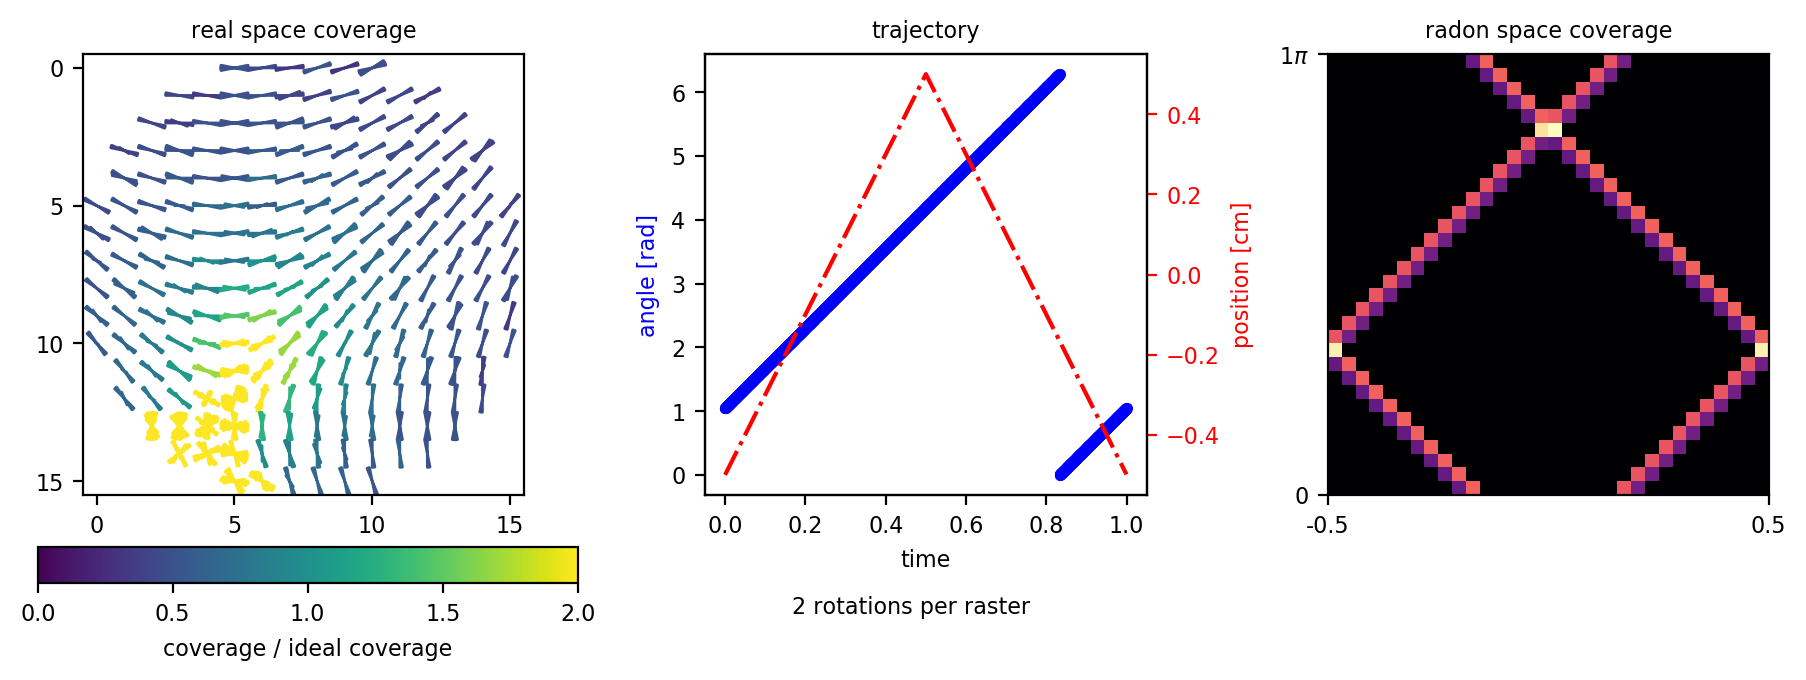

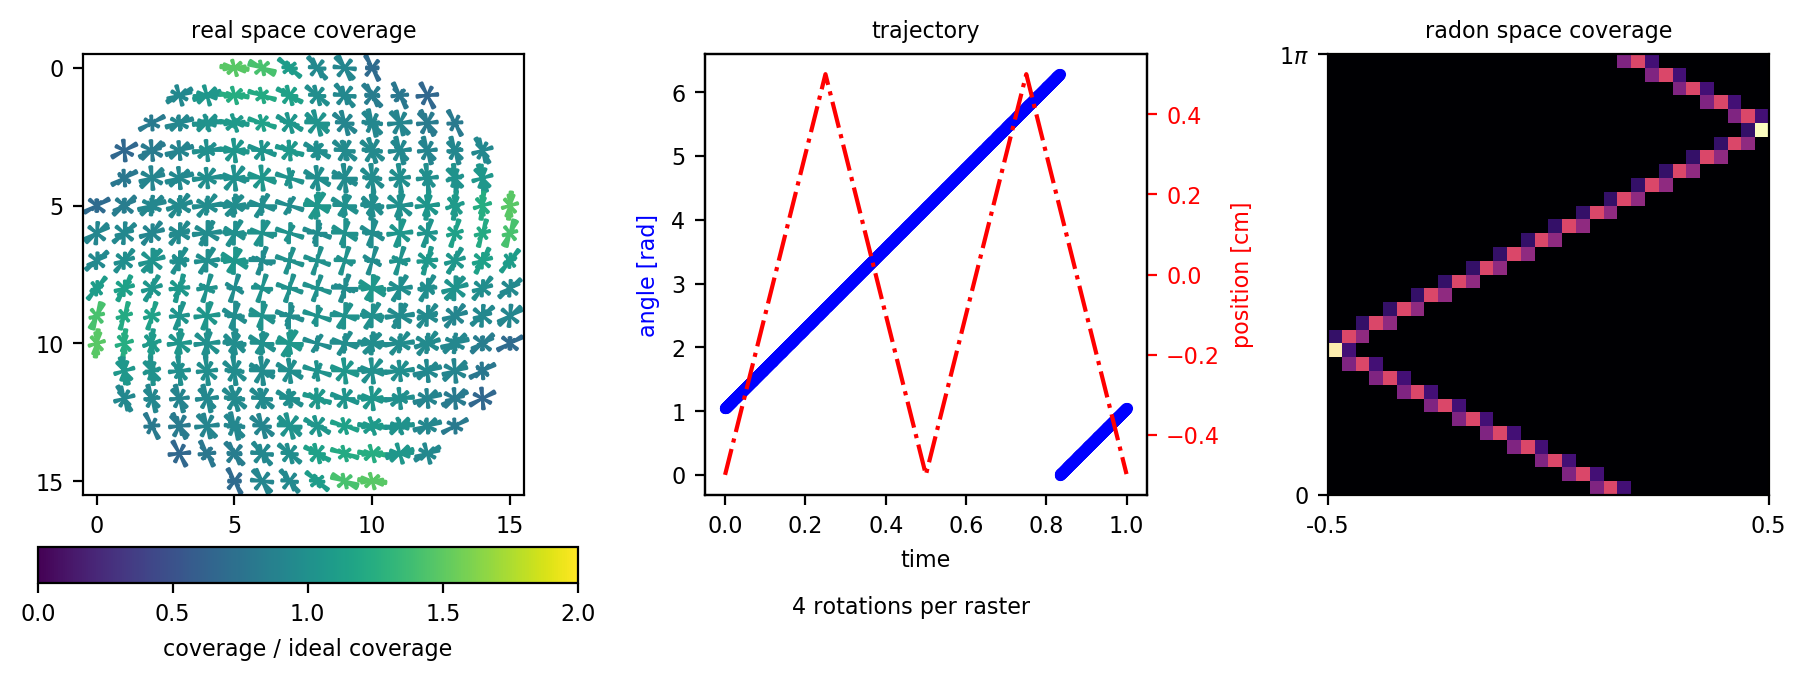

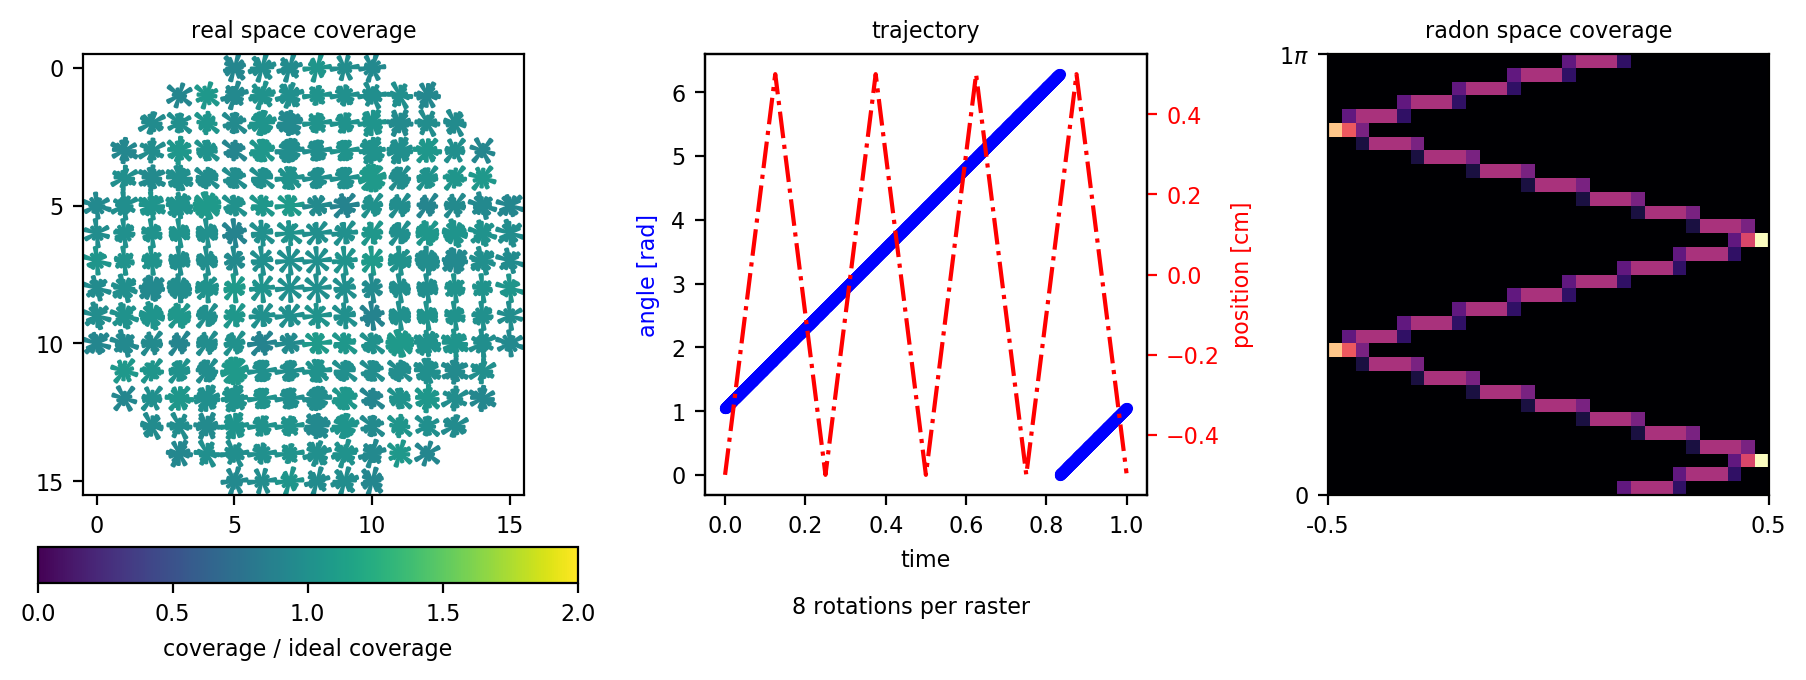

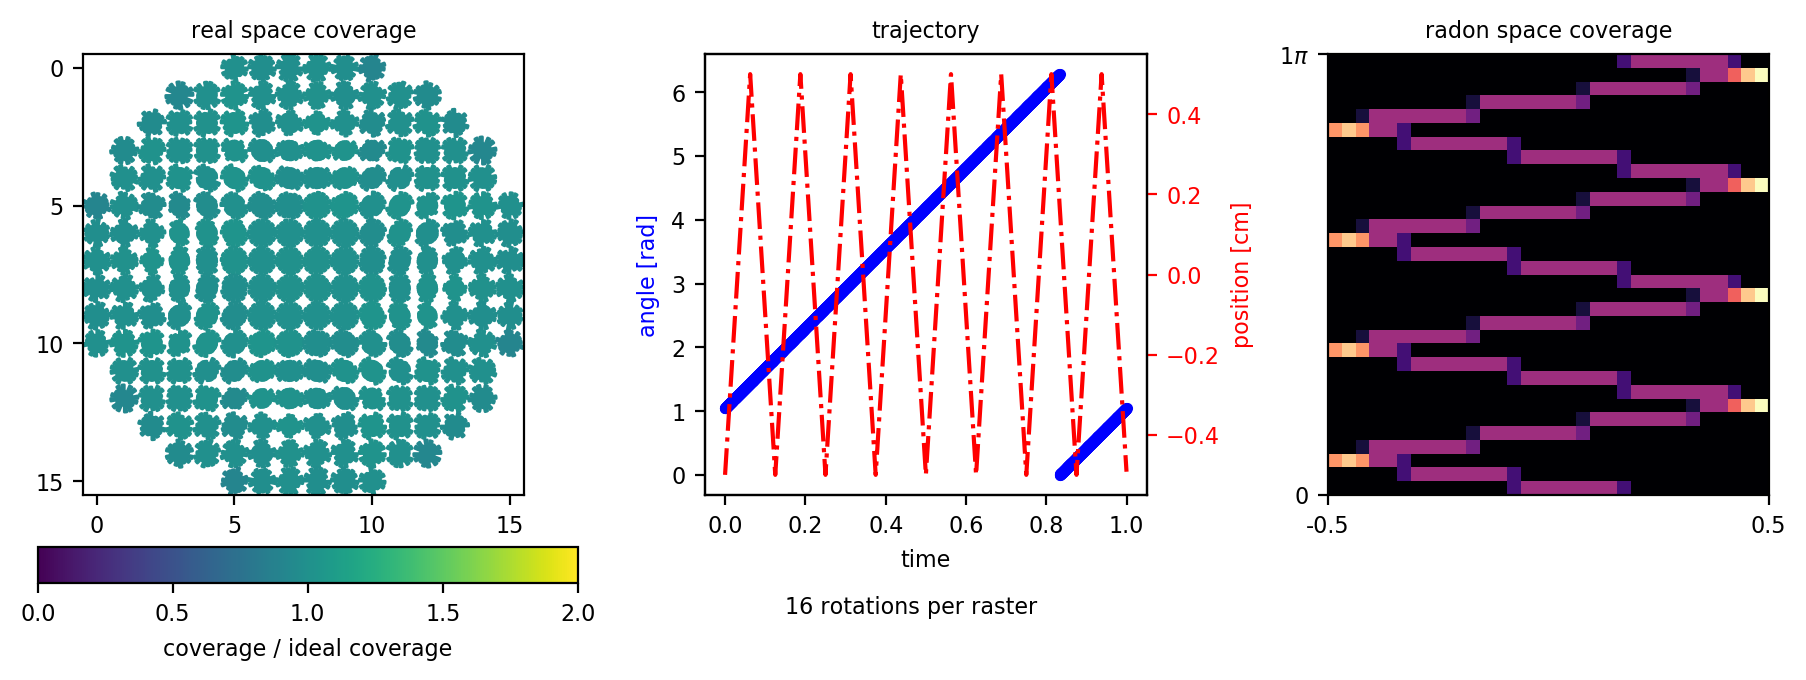

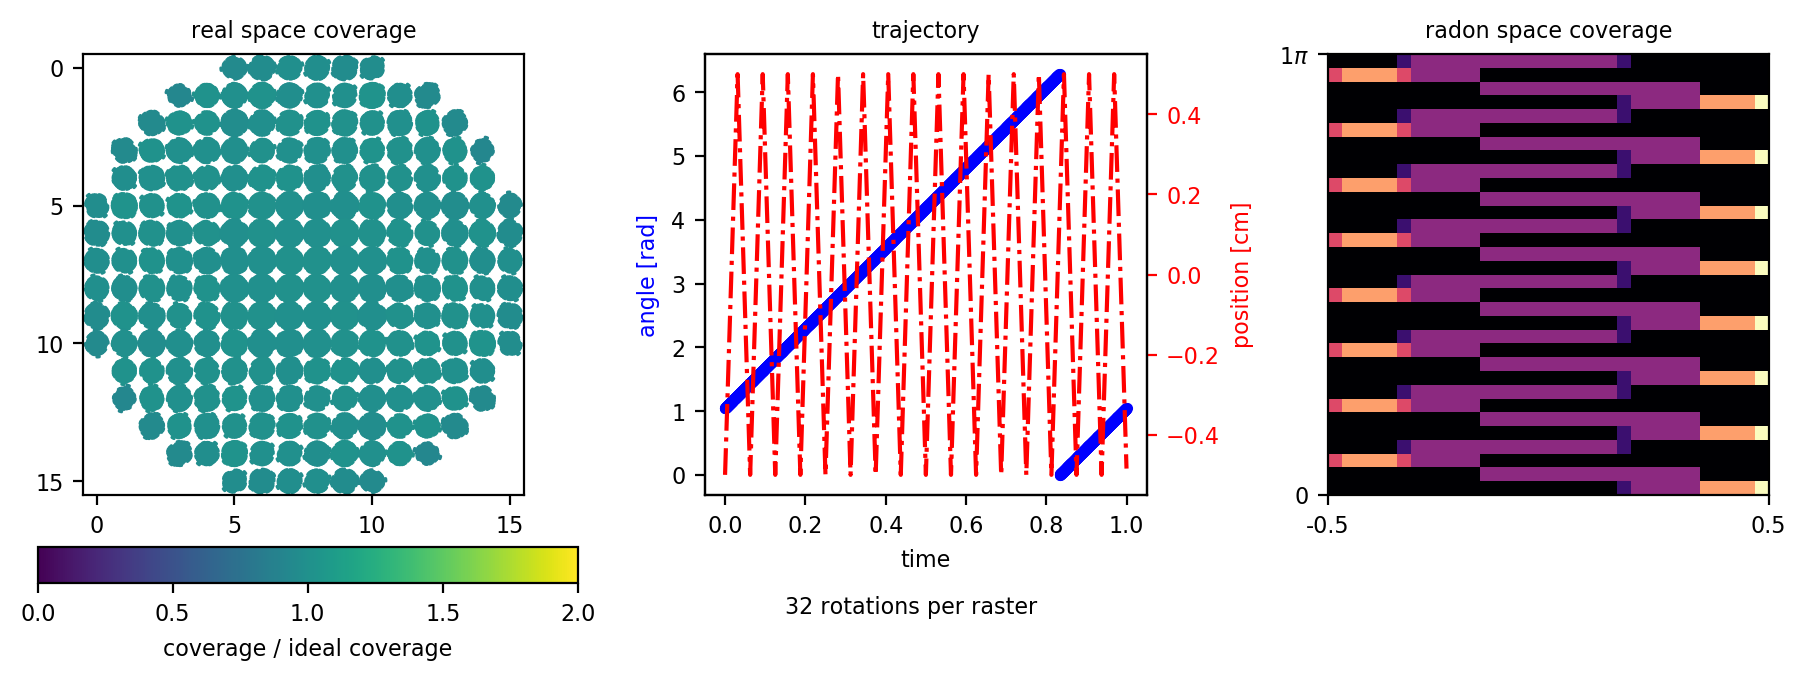

In [16]:
for i in range(len(tri_coverage_maps)):
    triple_plot(tri_coverage_maps[i], raster2Dt, num_rotations[i])

## Sinusoidal

In [17]:
# More traversals than rotations
num_rasters = num_rotations
sin_coverage_maps = list()
for R in num_rasters:
    kwargs = {'N_raster' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = probe.coverage(trajectory=raster2Ds, region=region,
                              pixel_size=PIXEL_SIZE,
                              tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                              tkwargs=kwargs, anisotropy=NANGLES)
    sin_coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 128 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 128 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 208 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 320 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 448 lines
INFO:root: coverage 4,096 element grid
INFO:tike.probe: line_width is 0.0625 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 832 lines
INFO:root: coverage 4,096 element grid


/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


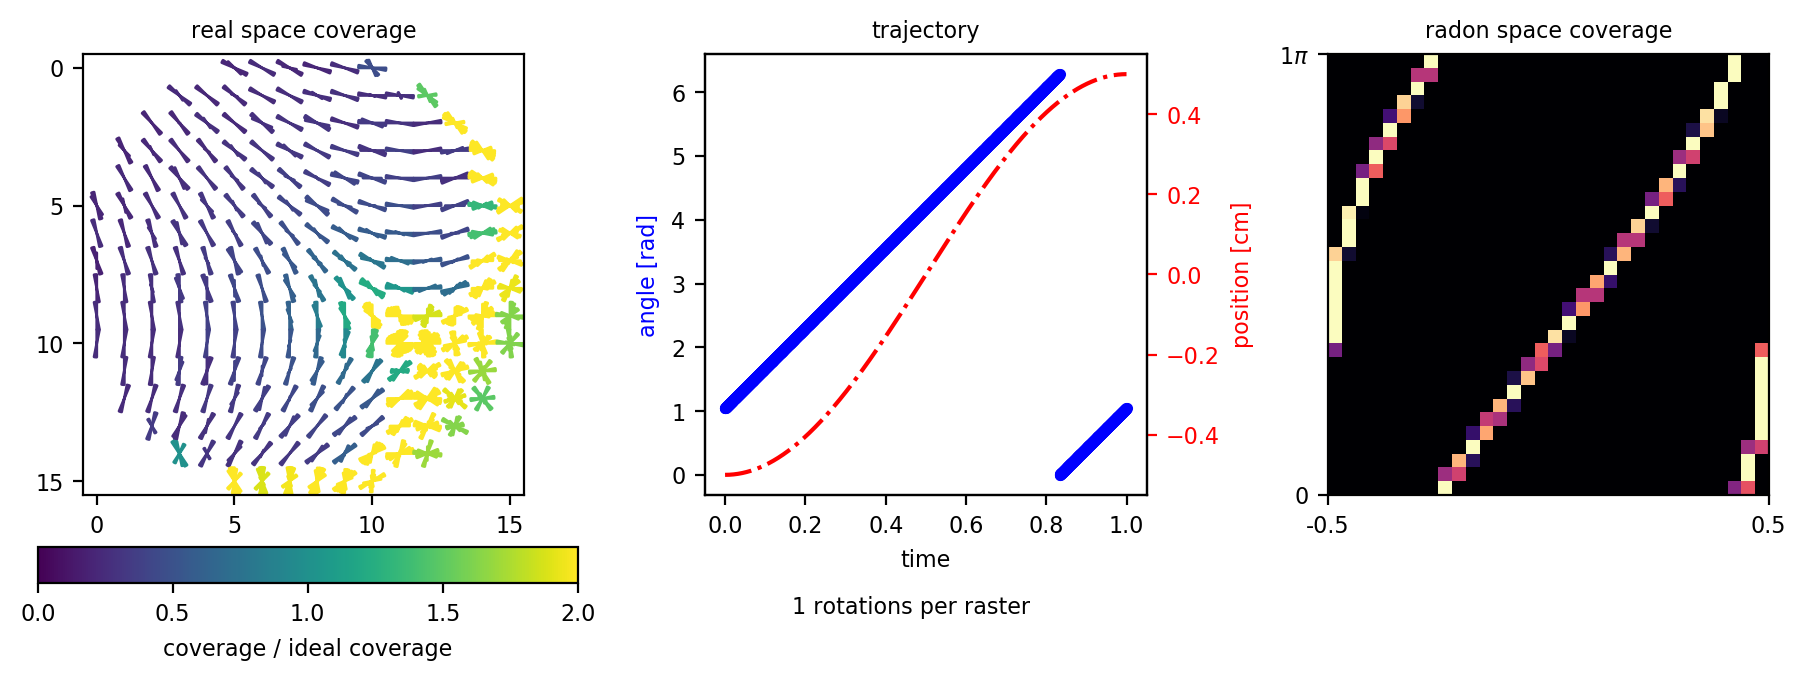

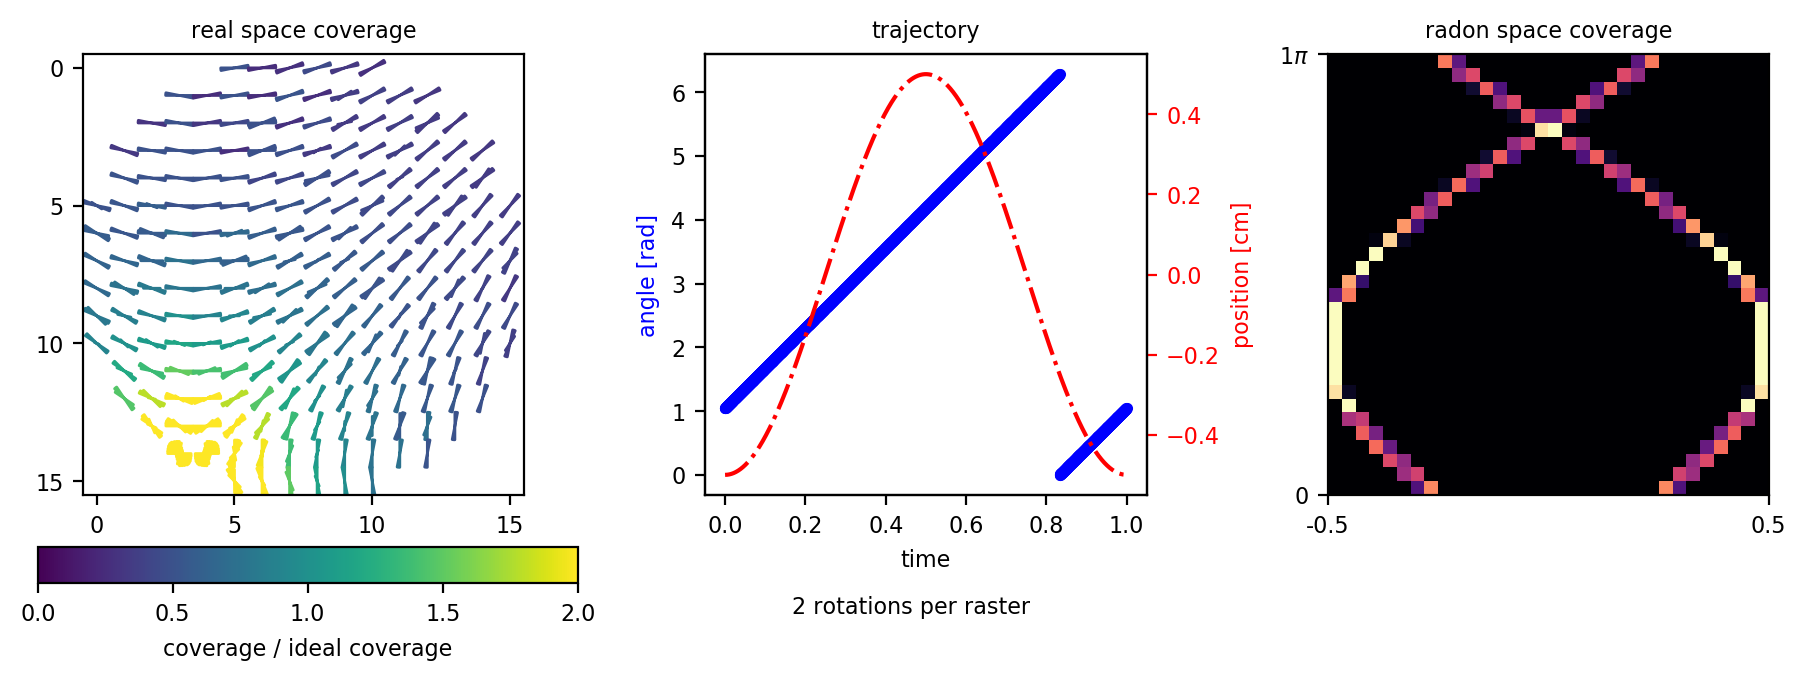

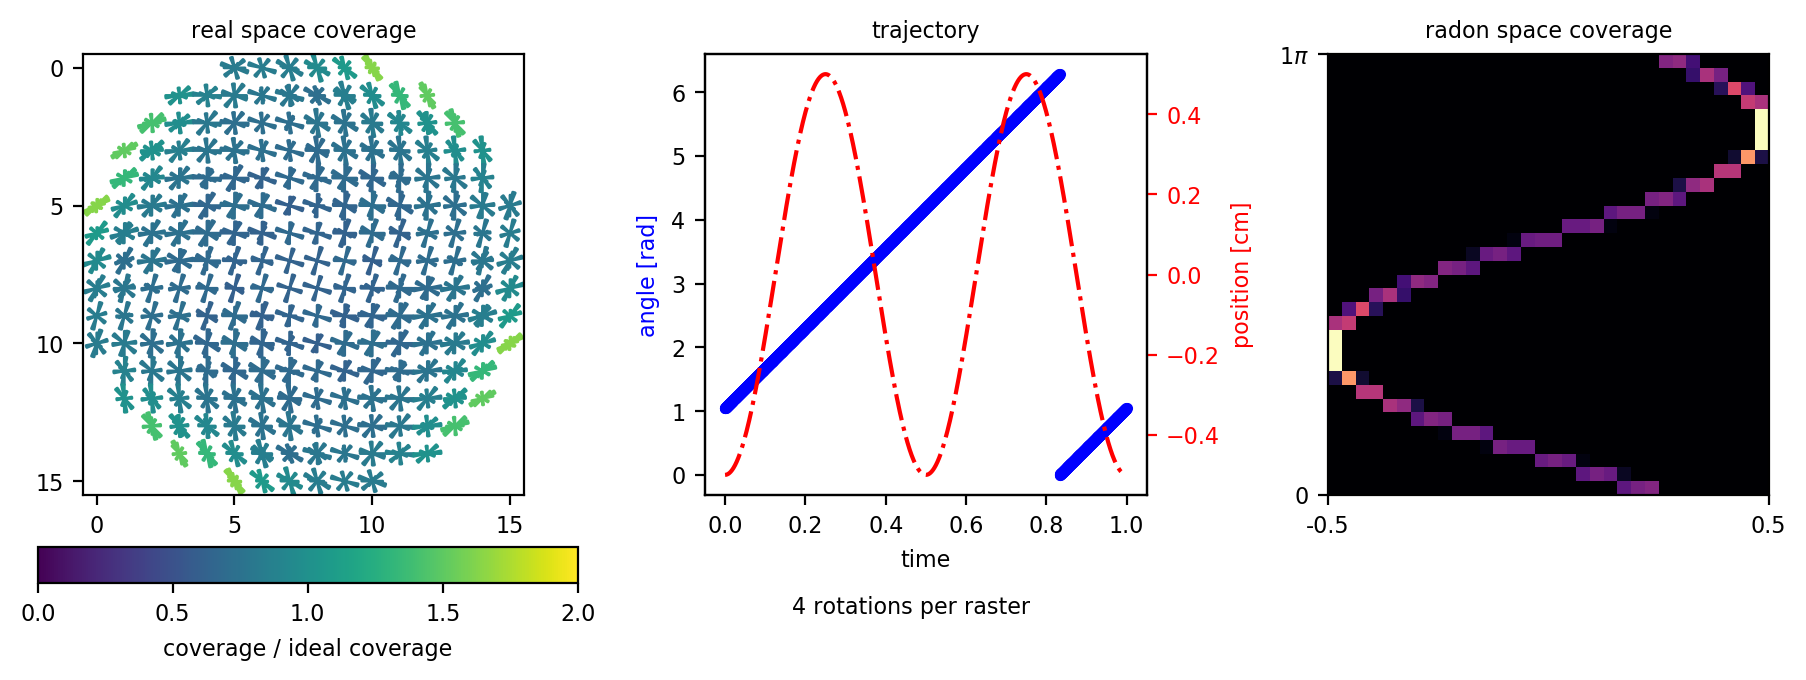

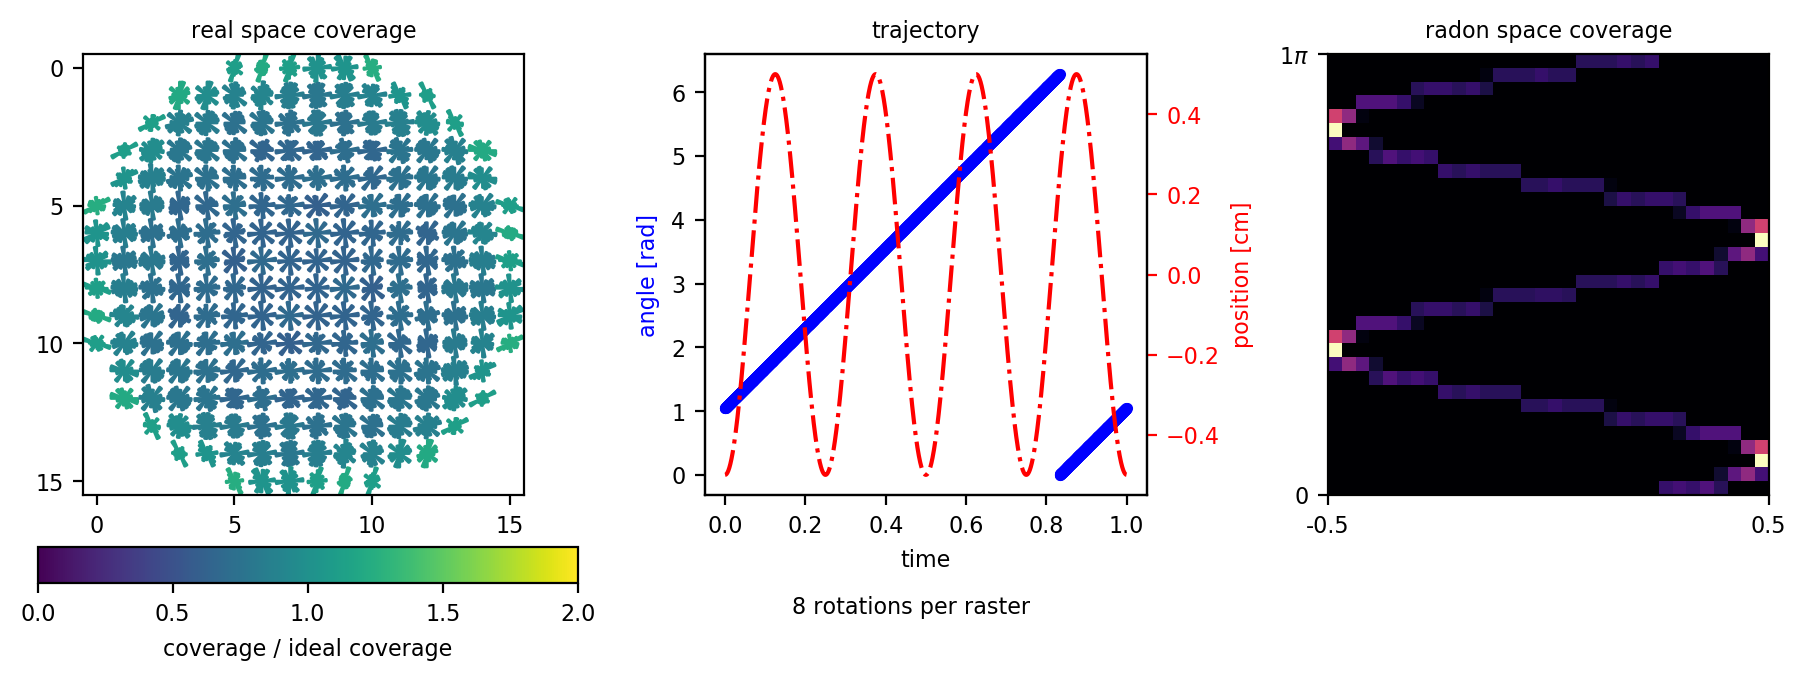

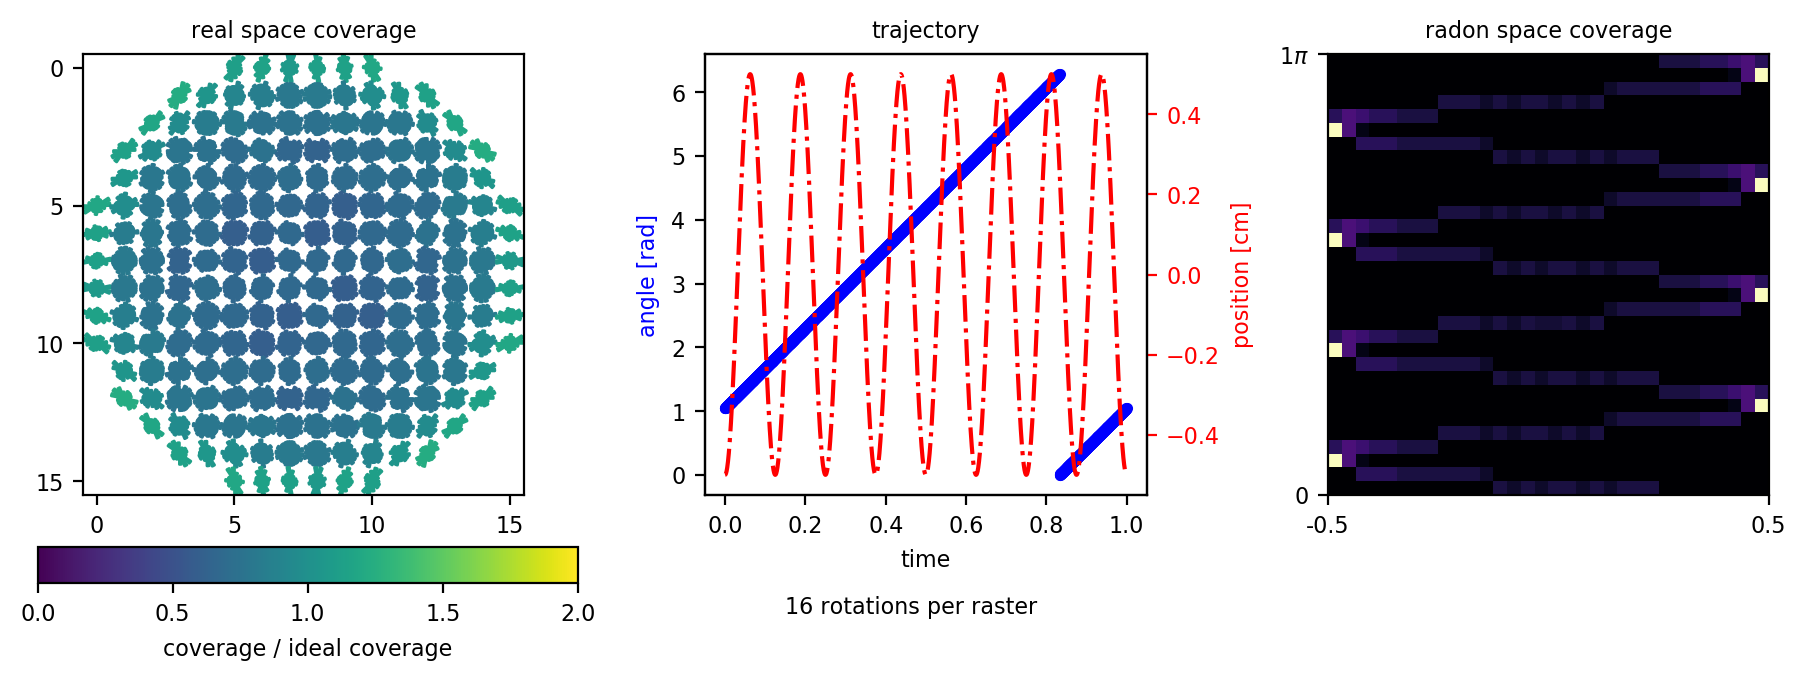

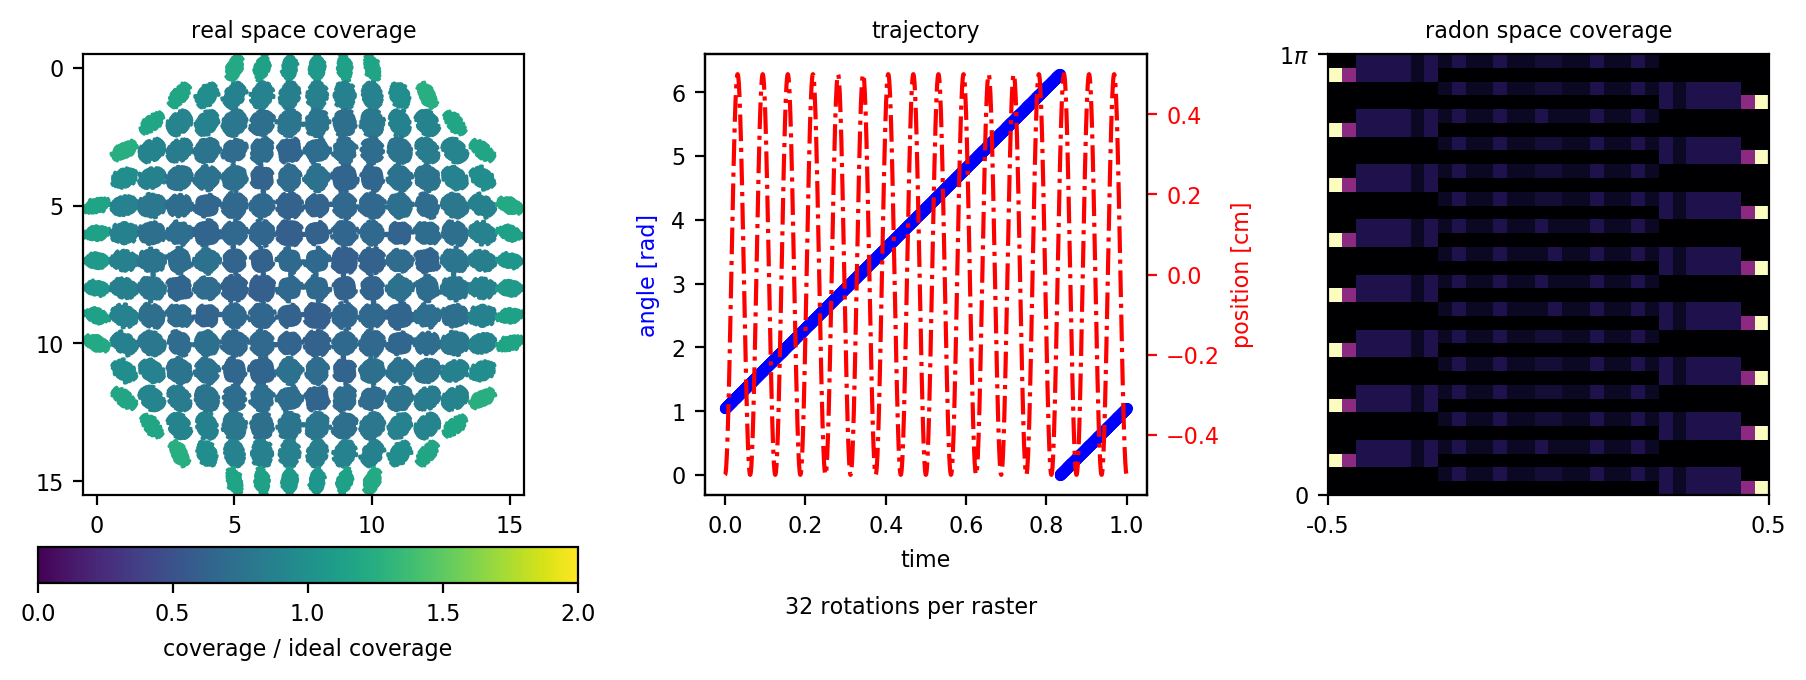

In [18]:
for i in range(len(sin_coverage_maps)):
    triple_plot(sin_coverage_maps[i], raster2Ds, num_rotations[i])

In [19]:
np.save('./data/{}_fly_coverage_maps.npy'.format(NPIXEL), fly_coverage_maps)
np.save('./data/{}_tri_coverage_maps.npy'.format(NPIXEL), tri_coverage_maps)
np.save('./data/{}_sin_coverage_maps.npy'.format(NPIXEL), sin_coverage_maps)
np.save('./data/{}_con_coverage_maps.npy'.format(NPIXEL), con_coverage_maps)

# Plot some summary things

/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


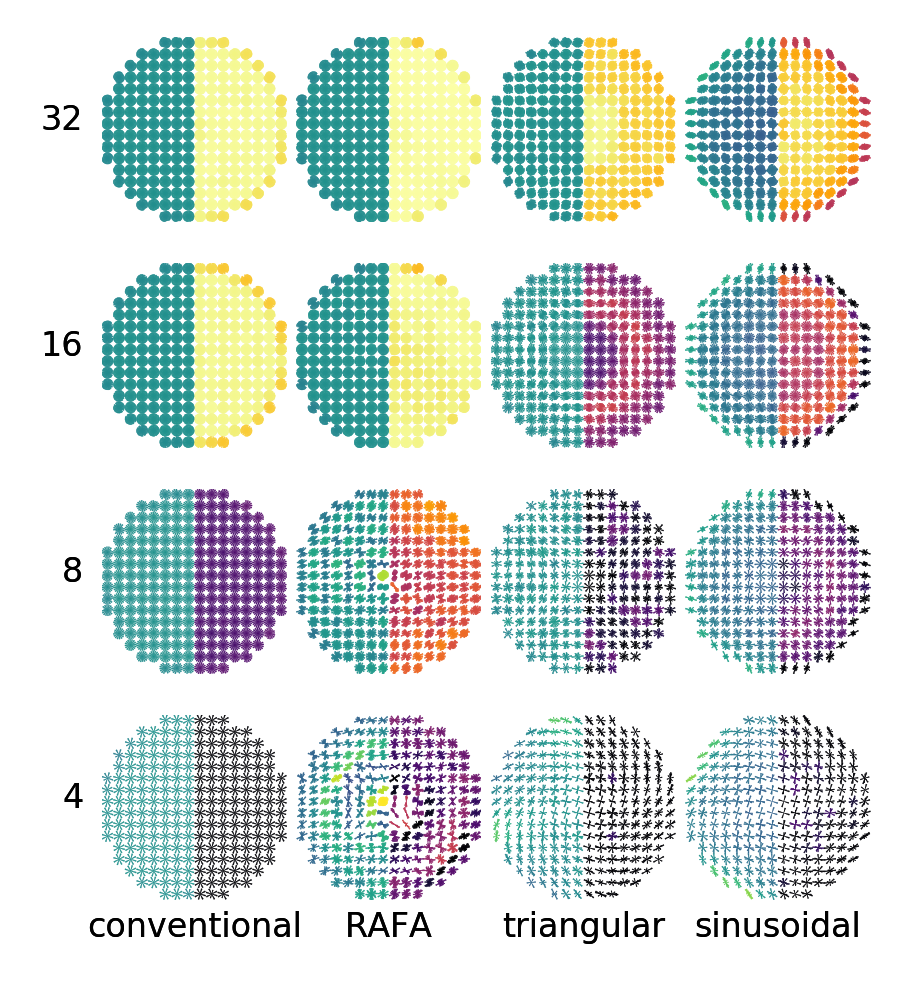

In [20]:
f1 = plt.figure(figsize=(8.4/2.54, 8.4/2.54), dpi=300, frameon=False)

for j in range(0, 2):
    fly_coverage_maps = np.load('./data/{}_fly_coverage_maps.npy'.format(NPIXEL))
    tri_coverage_maps = np.load('./data/{}_tri_coverage_maps.npy'.format(NPIXEL))
    sin_coverage_maps = np.load('./data/{}_sin_coverage_maps.npy'.format(NPIXEL))
    con_coverage_maps = np.load('./data/{}_con_coverage_maps.npy'.format(NPIXEL))
    
    if j == 0:
        plot_color = 'standard deviation'
        plot_normal = 0.005

        mask = get_mask(sin_coverage_maps[0])
        mask[:,0:mask.shape[0]//2] = False
    else:
        plot_color = 'coverage'
        plot_normal = 2*ideal_mean
        mask = get_mask(sin_coverage_maps[1])
        mask[:,mask.shape[0]//2:] = False

    width = len(fly_coverage_maps)
    for i in range(2, width):
        plt.subplot(width-2, 4, (5-i)*4 + 2)
        cm = fly_coverage_maps[i][0,...]
        cm[~mask, ...] = np.nan
        xd.plot_coverage_anisotropy(cm, trace_normal=plot_normal, color=plot_color, linewidth=0.1)
        plt.axis('off')
        if i == 2:
            plt.annotate('RAFA', (0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=8)



        plt.subplot(width-2, 4, (5-i)*4 + 3)
        cm = tri_coverage_maps[i][0,...]
        cm[~mask, ...] = np.nan
        xd.plot_coverage_anisotropy(cm, trace_normal=plot_normal, color=plot_color, linewidth=0.1)
        plt.axis('off')
        if i == 2:
            plt.annotate('triangular', (0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=8)



        plt.subplot(width-2, 4, (5-i)*4 + 4)
        cm = sin_coverage_maps[i][0,...]
        cm[~mask, ...] = np.nan
        xd.plot_coverage_anisotropy(cm, trace_normal=plot_normal, color=plot_color, linewidth=0.1)
        plt.axis('off')
        if i == 2:
            plt.annotate('sinusoidal', (0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=8)
        
        
        plt.subplot(width-2, 4, (5-i)*4 + 1)
        cm = con_coverage_maps[i][0,...]
        cm[~mask, ...] = np.nan
        xd.plot_coverage_anisotropy(cm, trace_normal=plot_normal, color=plot_color, linewidth=0.1)
        plt.axis('off')
        plt.annotate(num_rotations[i], (-0.1, 0.5), xycoords='axes fraction', ha='right', fontsize=8)
        if i == 2:
            plt.annotate('conventional', (0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.95, bottom=0.05)
# plt.tight_layout(pad=0.0)
plt.savefig('./figures/cover_compare.pdf', dpi=600)
plt.savefig('./figures/cover_compare.png', dpi=600)
plt.show()